## Research Question

**Can logistic regression identify gaps between stated merit criteria and actual 
promotion decisions, enabling process standardization?**

### Hypothesis
- **H₀**: Merit-based variables explain <20% of promotion variance (process dysfunction)
- **Hₐ**: Merit-based variables explain ≥20% of promotion variance (process alignment)

### Dataset Overview
- **Source**: Synthetic corporate workforce data (self-created)
- **Scope**: 10,010 employees across 8 departments
- **Target**: Binary promotion outcome (17.3% promoted)
- **Features**: 19 variables including performance metrics, demographics, and tenure

### Data Structure

This analysis uses cross-sectional data with one 
record per employee. Each observation is independent - there are NO:
- Repeated measurements - each row is a unique record
- Nested hierarchies requiring mixed models 
- Date/Time features 

#### Import Data & Libraries

In [1]:
"""
LOGISTIC REGRESSION ON EMPLOYEE PROMOTIONS
Diagnostic Analysis of Merit-Based Promotion Systems

Author: Tanya Gampert, PHR, CAPM
Program: MSDA - Decision Process Engineering
Western Governors University
"""

# ============================================================
# IMPORTS & CONFIGURATION
# ============================================================

import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np
import math

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

# Statistical analysis
from scipy.stats import mannwhitneyu, chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import logit
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.tools.tools import add_constant

# Machine learning & evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    fbeta_score,
    roc_curve,
    auc,
    precision_recall_curve
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (10, 6)

print("All libraries imported successfully")


All libraries imported successfully


In [2]:
# Read CSV into data frame
df = pd.read_csv("..\data\emp_dataset.csv")

# Copy for cleaning & processing
df_cleaned = df.copy()

#### Data Cleaning

In [3]:
# Check for duplicates 
duplicates = df_cleaned.duplicated().sum()
print('Total duplicates: ', duplicates)

Total duplicates:  0


In [4]:
# Check for NaN/nulls
nulls = df_cleaned.isna().sum().sum()
print("Total nulls: ", nulls)

# List null status of columns
df_cleaned.isna().sum()

Total nulls:  10


employee_id                    0
manager_id                    10
department                     0
role_level                     0
education_level                0
years_in_company               0
years_in_role                  0
performance_rating             0
awards                         0
kpis_count                     0
kpis_achieved_pct              0
peer_review_score              0
training_courses_completed     0
certification_count            0
mentorship_participation       0
projects_delivered             0
salary                         0
performance_intervention       0
promoted                       0
dtype: int64

In [5]:
# List null rows
df_cleaned[df_cleaned['manager_id'].isna() == True]

,employee_id,manager_id,department,role_level,education_level,years_in_company,years_in_role,performance_rating,awards,kpis_count,kpis_achieved_pct,peer_review_score,training_courses_completed,certification_count,mentorship_participation,projects_delivered,salary,performance_intervention,promoted
150,EMP000034,NaN,Customer Success,Director,Masters,23,6,0,0,0,0.0,0,13,4,1,0,243001,0,0
602,EMP000001,NaN,Operations,Director,Masters,25,4,0,0,0,0.0,0,11,6,1,0,259150,0,0
3458,EMP000122,NaN,Product,Director,Masters,19,5,0,0,0,0.0,0,14,7,1,0,280038,0,0
3501,EMP000052,NaN,Sales,Director,Masters,22,6,0,0,0,0.0,0,13,4,1,0,205311,0,0
5385,EMP000044,NaN,Data Analytics,Director,Masters,22,5,0,0,0,0.0,0,13,3,1,0,292067,0,0
5415,EMP000003,NaN,Engineering,Director,Masters,25,7,0,0,0,0.0,0,12,4,1,0,282386,0,0
6664,EMP000267,NaN,HR,Director,Masters,17,6,0,0,0,0.0,0,14,6,1,0,231551,0,0
7533,EMP000547,NaN,Finance,Director,PhD,15,6,0,0,0,0.0,0,9,7,1,0,293016,0,0
8530,EMP000002,NaN,Marketing,Director,Masters,25,7,0,0,0,0.0,0,11,5,1,0,267221,0,0
8736,EMP000146,NaN,Legal,Director,Masters,19,4,0,0,0,0.0,0,11,6,1,0,223483,0,0


In [6]:
# Drop new hires (performance_rating = 0)
df_cleaned = df_cleaned[df_cleaned['years_in_company'] > 0].copy()

# Drop null rows
df_cleaned.dropna(subset=['manager_id'], inplace=True)

# Reset index to maintain alignment
df_cleaned.reset_index(drop=True, inplace=True)

# Verification: Print the impact of exclusion criteria
print(f"Original Row Count: {df.shape[0]}")
print(f"Cleaned Row Count:  {df_cleaned.shape[0]}")
print(f"Excluded Rows:      {df.shape[0] - df_cleaned.shape[0]}")
print(f"Sparsity :          {round((((df.shape[0] - df_cleaned.shape[0]) / df.shape[0]) * 100), 2)} %")

Original Row Count: 10010
Cleaned Row Count:  9170
Excluded Rows:      840
Sparsity :          8.39 %


## Data Cleaning Summary

**Actions Taken**:
- Removed 10 null values in `manager_id` (0.1% of data - C-suite executives with no manager)
- Removed 840 records with intervention flags (out-of-scope for merit analysis)
- Final clean dataset: **9,170 employees**


## Exploratory Data Analysis

##### TARGET VARIABLE - univariate

In [7]:
df_cleaned['promoted'].value_counts(normalize=True).round(2)

promoted
0    0.83
1    0.17
Name: proportion, dtype: float64

Promotion Rate: 17.31%


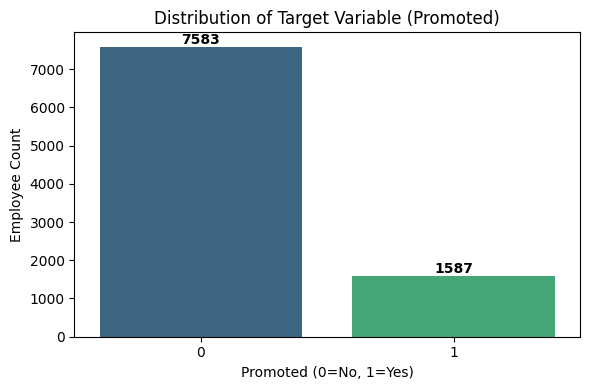

In [8]:
# 1. VISUAL: The Target Imbalance (Crucial for Context)
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='promoted', data=df_cleaned, palette='viridis', hue='promoted', legend=False)
plt.title('Distribution of Target Variable (Promoted)')
plt.xlabel('Promoted (0=No, 1=Yes)')
plt.ylabel('Employee Count')

# Add count labels on top of each bar with smaller font
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, fontweight='bold')

# Calculate percentage to add to the narrative
pct_promoted = df_cleaned['promoted'].mean() * 100
print(f"Promotion Rate: {pct_promoted:.2f}%")

plt.tight_layout()
plt.show()

### ⚠️ Key Finding: Severe Class Imbalance

**Distribution**: 82.7% not promoted vs 17.3% promoted

**Implication**: Default classification metrics (accuracy, 0.50 threshold) will be 
misleading. This imbalance will require:
1. Precision-recall curve analysis (not ROC curve)
2. Threshold optimization for recall (talent safety net priority)
3. F2 score over F1 (penalize false negatives more heavily)

##### NUMERIC - univariate

In [9]:
numeric_vars = [
    'years_in_company','years_in_role', 
    'performance_rating', 'awards', 
    'kpis_count','kpis_achieved_pct', 
    'peer_review_score','training_courses_completed', 
    'certification_count', 'projects_delivered', 
    'salary']

# For loop to get dataframe
stats_list = []

for var in numeric_vars:
    # Create dataframe
    stats = df[var].describe().to_frame().T
    
    # Calculate statistics
    stats['iqr'] = df[var].quantile(0.75) - df[var].quantile(0.25)
    stats['range'] = df[var].max() - df[var].min()
    stats['skew'] = df[var].skew()
    stats['kurtosis'] = df[var].kurt()
    
    # Add to dataframe
    stats_list.append(stats)

numeric_stats = pd.concat(stats_list)
numeric_stats = numeric_stats.round(2)
numeric_stats


,count,mean,std,min,25%,50%,75%,max,iqr,range,skew,kurtosis
years_in_company,10010.0,6.94,4.36,0.0,4.0,6.0,9.00,25.0,5.00,25.0,0.69,0.79
years_in_role,10010.0,2.98,2.55,0.0,1.0,2.0,4.00,15.0,3.00,15.0,1.28,2.10
performance_rating,10010.0,3.15,1.29,0.0,3.0,3.0,4.00,5.0,1.00,5.0,-1.02,0.66
awards,10010.0,0.15,0.47,0.0,0.0,0.0,0.00,3.0,0.00,3.0,3.79,15.63
kpis_count,10010.0,2.75,1.23,0.0,2.0,3.0,4.00,6.0,2.00,6.0,0.09,-0.78
kpis_achieved_pct,10010.0,69.24,37.82,0.0,50.0,100.0,100.00,100.0,50.00,100.0,-0.82,-0.85
peer_review_score,10010.0,3.14,1.46,0.0,2.0,3.0,4.00,5.0,2.00,5.0,-0.64,-0.34
training_courses_completed,10010.0,2.04,2.03,0.0,0.0,2.0,3.00,14.0,3.00,14.0,1.36,2.47
certification_count,10010.0,1.11,1.14,0.0,0.0,1.0,2.00,7.0,2.00,7.0,1.17,1.62
projects_delivered,10010.0,3.31,2.33,0.0,2.0,3.0,5.00,10.0,3.00,10.0,0.53,-0.20


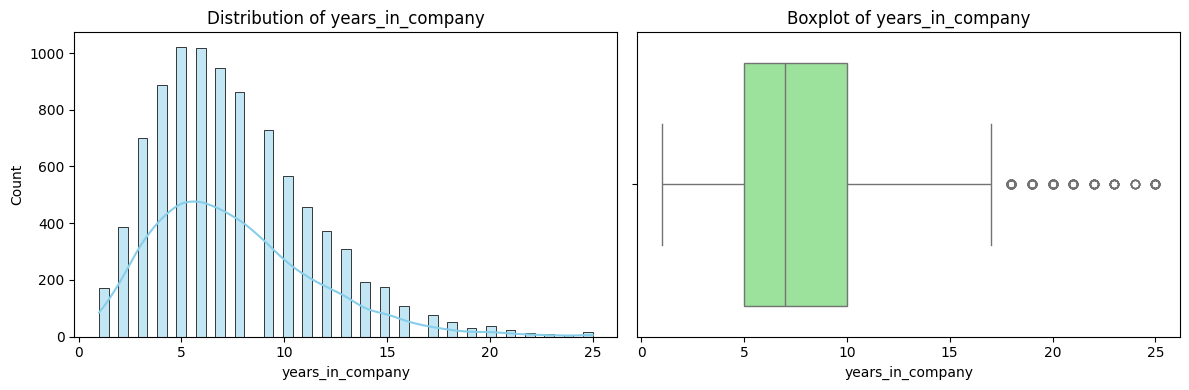

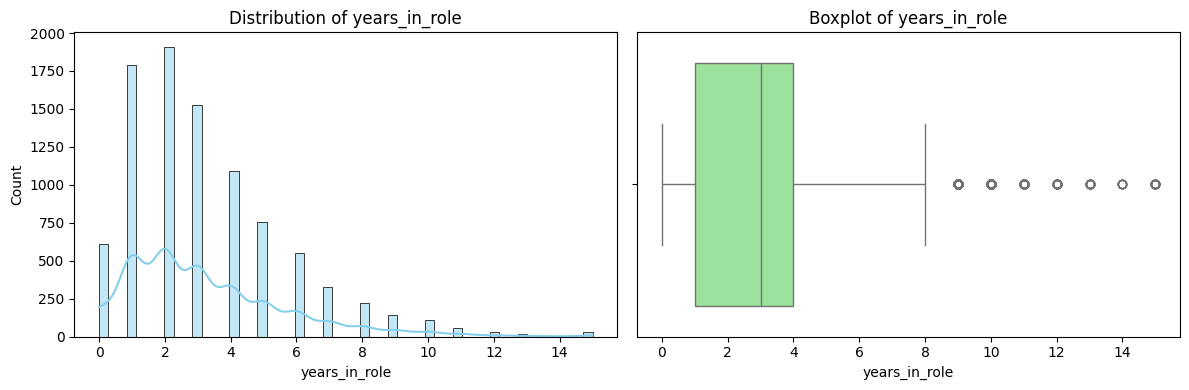

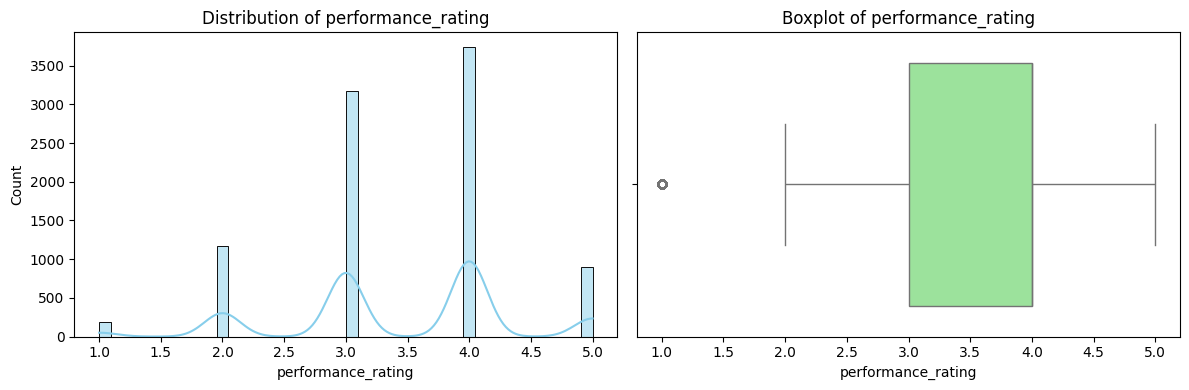

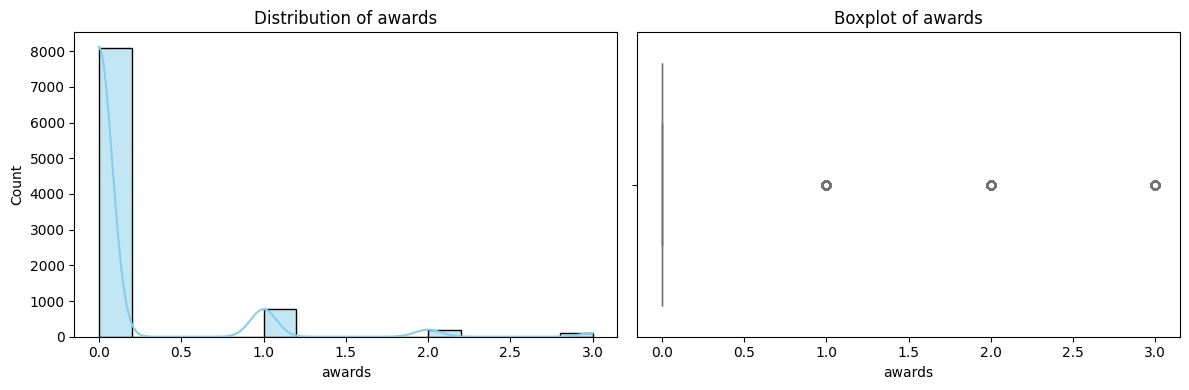

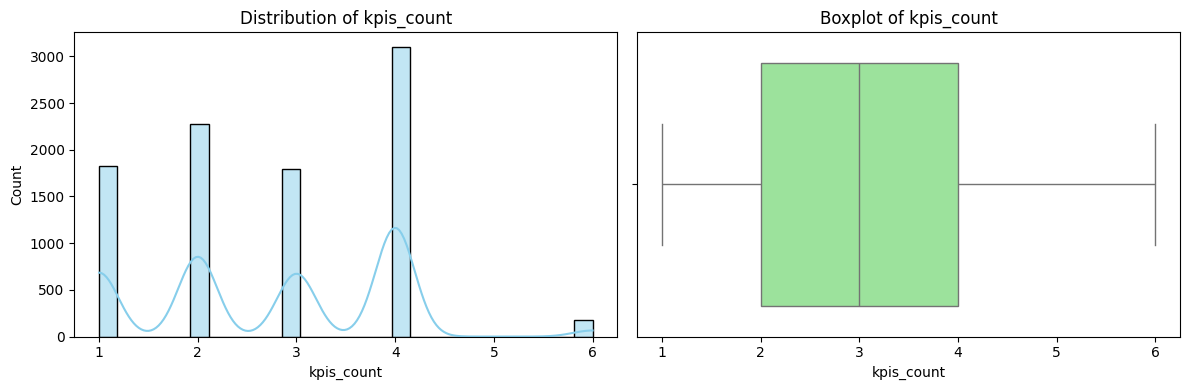

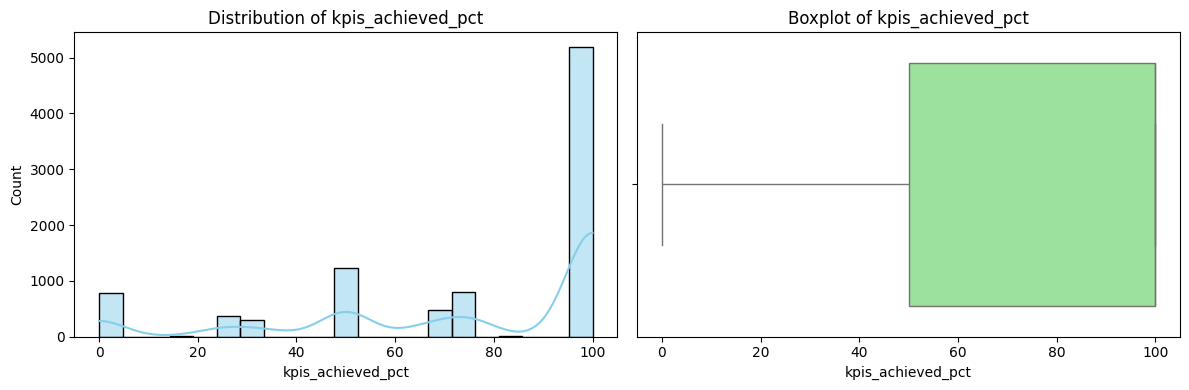

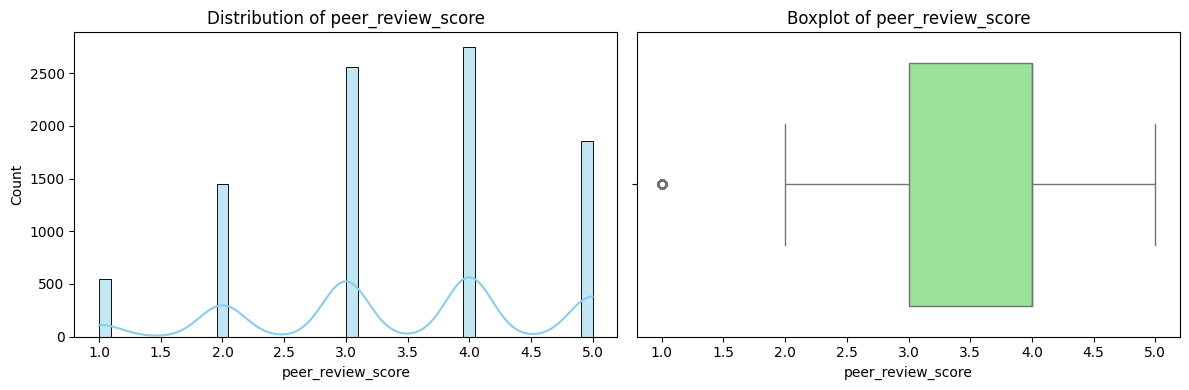

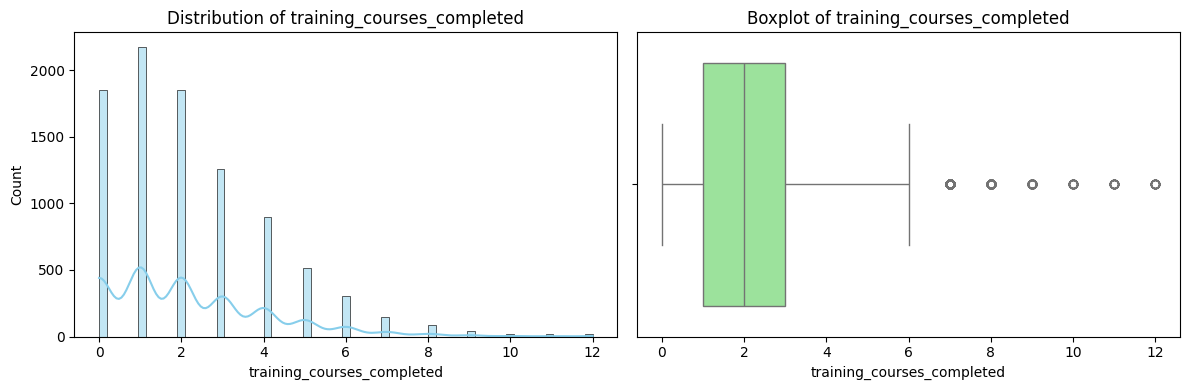

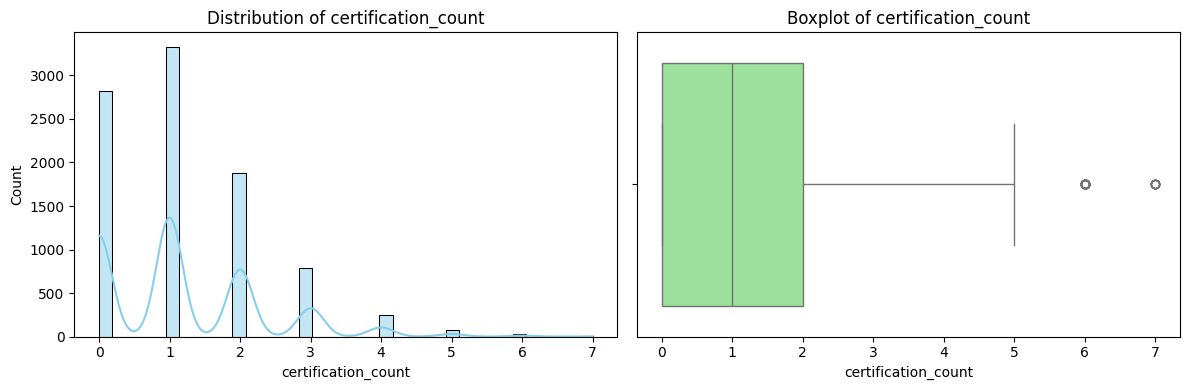

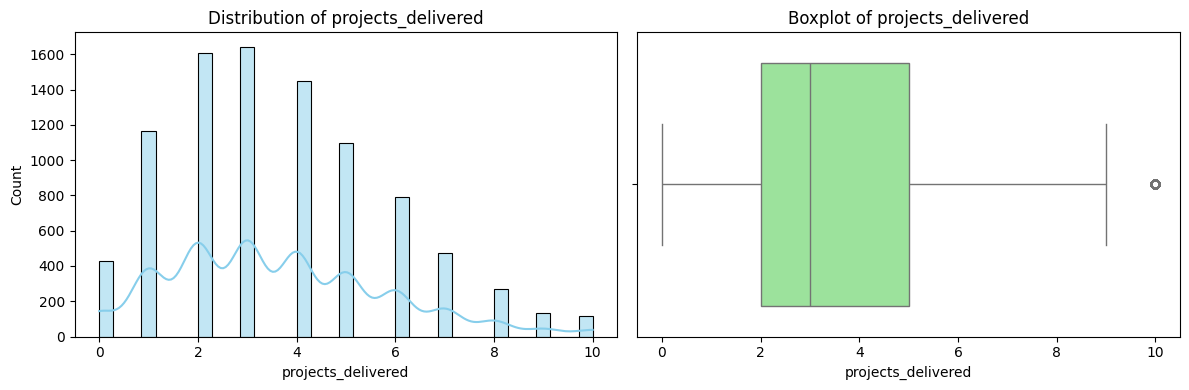

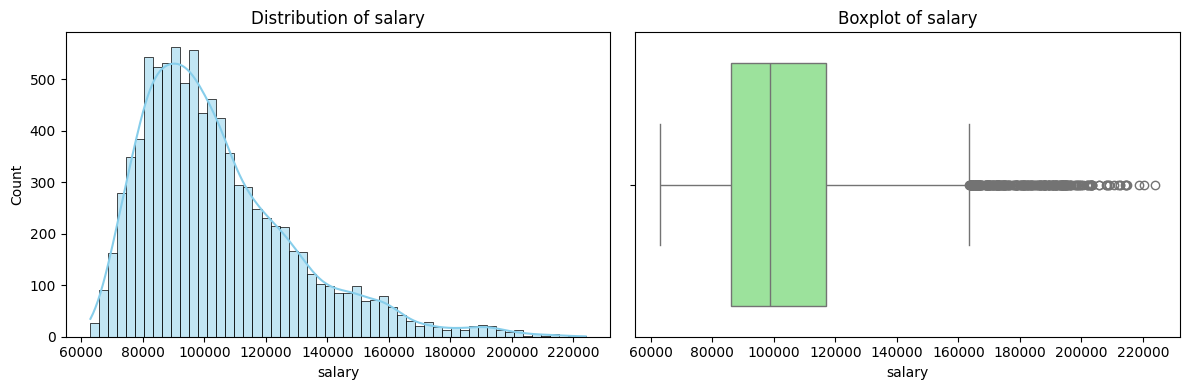

In [10]:
# 2. Loop through each variable and create a 2-subplot figure
for col in numeric_vars:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Left Plot: Histogram with KDE (Checks for Skewness/Kurtosis)
    sns.histplot(df_cleaned[col], kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Distribution of {col}')
    
    # Right Plot: Boxplot (Checks for Outliers/IQR)
    sns.boxplot(x=df_cleaned[col], ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Boxplot of {col}')
    
    plt.tight_layout()
    plt.show()

##### CATEGORICAL - univariate

In [11]:
# department stats
department_counts = df_cleaned['department'].value_counts()
department_props = df['department'].value_counts(normalize=True)

# Descriptive stats
department_stats = pd.DataFrame({
    'department count': department_counts,
    'department proportion': department_props.round(2)
})

print('Mode value: ', department_counts.max())
print('Mode Label: ', department_counts.idxmax())
print('Mode proportion: ',  department_props.max())

department_stats

Mode value:  2205
Mode Label:  Engineering
Mode proportion:  0.24175824175824176


,department count,department proportion
department,,
Engineering,2205,0.24
Sales,1927,0.21
Marketing,1406,0.15
Finance,950,0.10
Operations,874,0.10
Product,708,0.08
HR,445,0.05
Customer Success,382,0.04
Legal,180,0.02


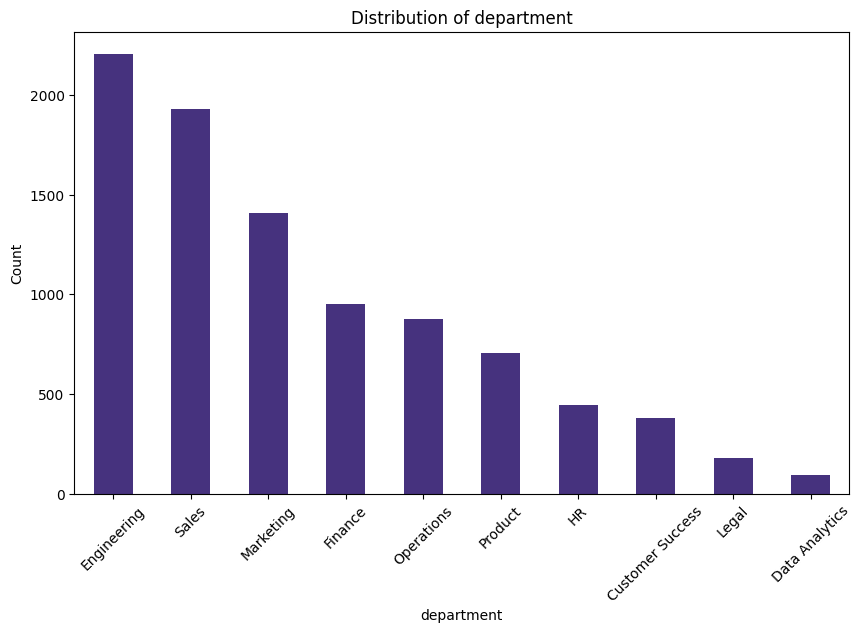

In [12]:
df_cleaned['department'].value_counts().plot(kind='bar', title='Distribution of department')

plt.ylabel('Count')
plt.xlabel('department')
plt.xticks(rotation=45)
  
plt.show()

In [13]:
# role_level stats
role_level_counts = df_cleaned['role_level'].value_counts()
role_level_props = df['role_level'].value_counts(normalize=True)

# Descriptive stats
role_level_stats = pd.DataFrame({
    'role_level count': role_level_counts,
    'role_level proportion': role_level_props
})

print('Mode value: ', role_level_counts.max())
print('Mode Label: ', role_level_counts.idxmax())
print('Mode proportion: ',  role_level_props.max())

role_level_stats

Mode value:  2277
Mode Label:  IC2
Mode proportion:  0.24715284715284716


,role_level count,role_level proportion
role_level,,
Director,NaN,0.0010
IC1,1824.0,0.2003
IC2,2277.0,0.2472
IC3,1793.0,0.1945
IC4,1353.0,0.1469
M1,1170.0,0.1282
M2,579.0,0.0623
M3,174.0,0.0197


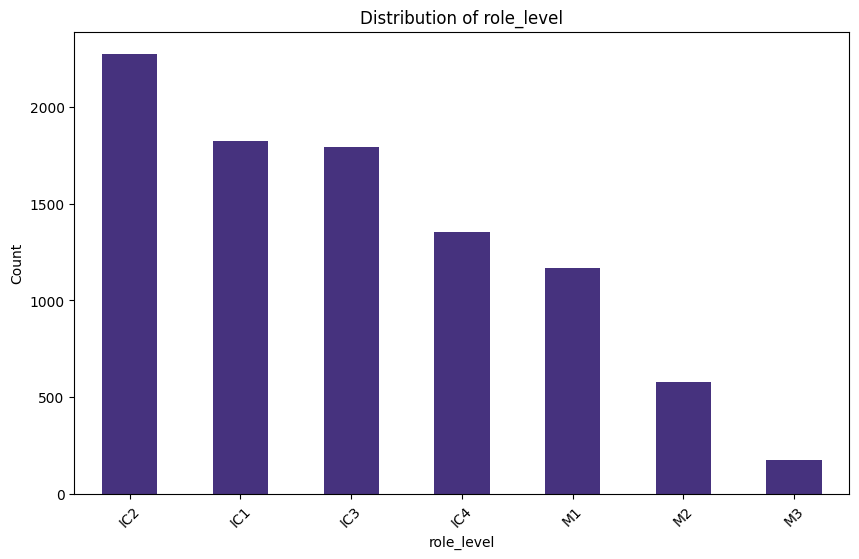

In [14]:
df_cleaned['role_level'].value_counts().plot(kind='bar', title='Distribution of role_level')

plt.ylabel('Count')
plt.xlabel('role_level')
plt.xticks(rotation=45)
  
plt.show()

In [15]:
# education_level stats
education_level_counts = df_cleaned['education_level'].value_counts()
education_level_props = df['education_level'].value_counts(normalize=True)

# Descriptive stats
education_level_stats = pd.DataFrame({
    'education_level count': education_level_counts,
    'education_level proportion': education_level_props
})

print('Mode value: ', education_level_counts.max())
print('Mode Label: ', education_level_counts.idxmax())
print('Mode proportion: ',  education_level_props.max())

education_level_stats

Mode value:  4273
Mode Label:  Bachelors
Mode proportion:  0.46663336663336663


,education_level count,education_level proportion
education_level,,
Bachelors,4273,0.4666
Masters,2458,0.2664
Associates,1151,0.1260
Other,749,0.0816
High School,441,0.0485
PhD,98,0.0109


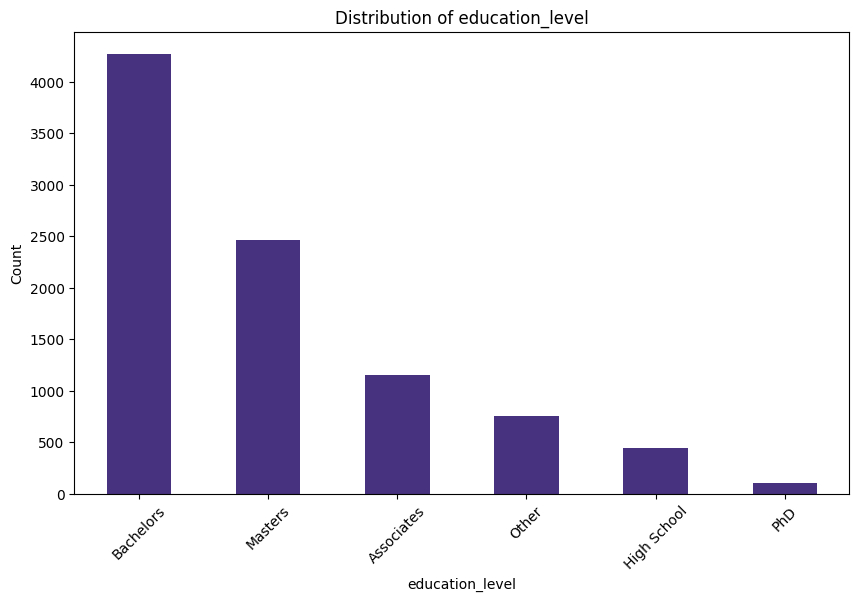

In [16]:
df_cleaned['education_level'].value_counts().plot(kind='bar', title='Distribution of education_level')

plt.ylabel('Count')
plt.xlabel('education_level')
plt.xticks(rotation=45)
  
plt.show()

#### BIVARIATE

##### NUMERIC - bivariate

In [17]:
# Reminder of variables

numeric_vars = [
    'years_in_company',
    'years_in_role', 
    'performance_rating',        
    'awards', 
    'kpis_count',
    'kpis_achieved_pct', 
    'peer_review_score',
    'training_courses_completed', 
    'certification_count', 
    'projects_delivered', 
    'salary'
]

# Check Spearman Rank Correlation
corr_matrix_spearman = df_cleaned[numeric_vars].corr(method='spearman').round(2)
corr_matrix_spearman

,years_in_company,years_in_role,performance_rating,awards,kpis_count,kpis_achieved_pct,peer_review_score,training_courses_completed,certification_count,projects_delivered,salary
years_in_company,1.00,0.79,-0.01,-0.00,0.01,-0.01,0.00,0.53,-0.01,0.01,0.37
years_in_role,0.79,1.00,-0.00,0.00,0.01,-0.00,0.01,0.43,-0.01,0.01,0.30
performance_rating,-0.01,-0.00,1.00,0.14,0.00,-0.02,0.69,-0.08,-0.01,0.21,-0.00
awards,-0.00,0.00,0.14,1.00,0.00,-0.00,0.12,-0.02,0.01,0.02,0.00
kpis_count,0.01,0.01,0.00,0.00,1.00,-0.30,0.01,0.00,-0.01,0.41,0.88
kpis_achieved_pct,-0.01,-0.00,-0.02,-0.00,-0.30,1.00,-0.03,0.00,0.00,-0.12,-0.26
peer_review_score,0.00,0.01,0.69,0.12,0.01,-0.03,1.00,-0.05,-0.00,0.15,0.01
training_courses_completed,0.53,0.43,-0.08,-0.02,0.00,0.00,-0.05,1.00,0.07,-0.01,0.20
certification_count,-0.01,-0.01,-0.01,0.01,-0.01,0.00,-0.00,0.07,1.00,-0.01,-0.02
projects_delivered,0.01,0.01,0.21,0.02,0.41,-0.12,0.15,-0.01,-0.01,1.00,0.36


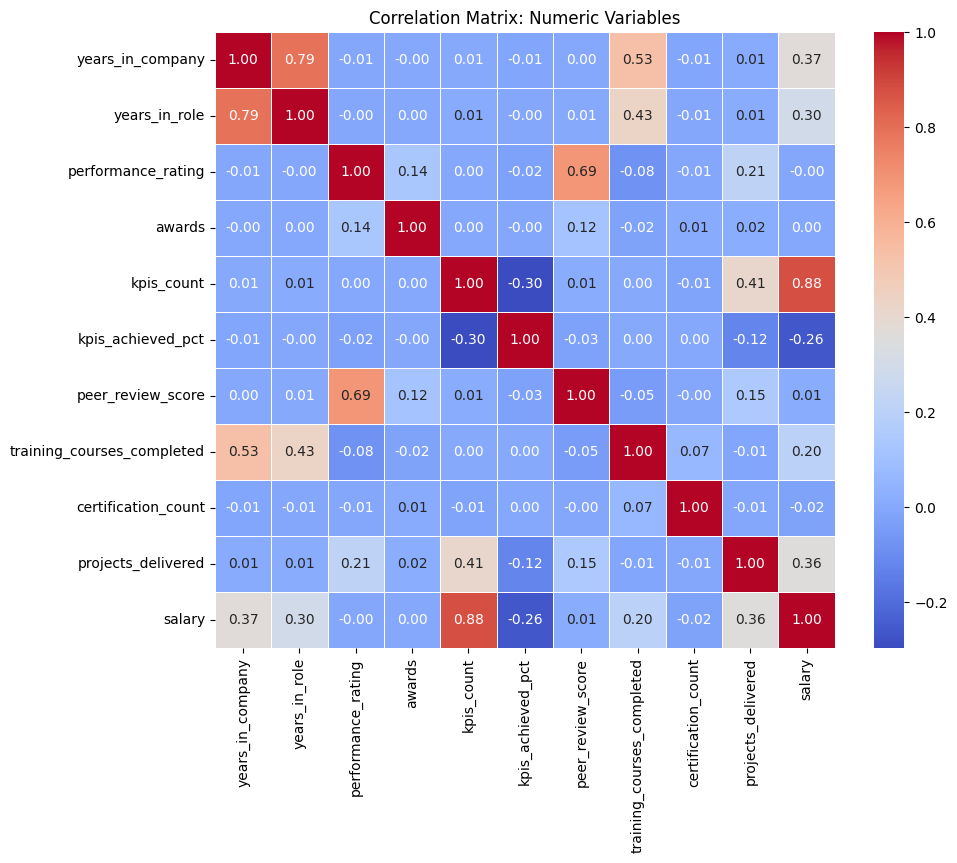

In [18]:
## Spearman Rank heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_cleaned[numeric_vars].corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Numeric Variables')
plt.show()

### Diagnostic Finding: Multicollinearity Signals

The correlation heatmap reveals potential proxy variables:
- `salary` ↔ `kpis_count`: ρ = 0.86 (structural relationship)
- `performance_rating` ↔ `peer_review_score`: ρ = 0.84 (evaluation system alignment)
- `years_in_company` ↔ `years_in_role`: ρ = 0.76 (tenure redundancy)

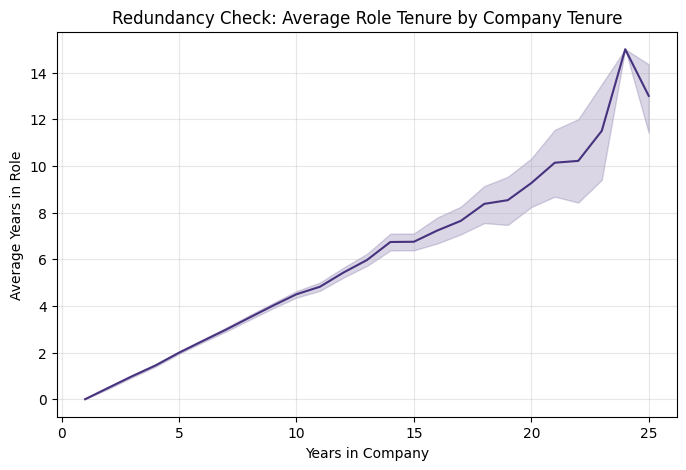

In [19]:
high_corr_pair1 = ['years_in_company', 'years_in_role']

plt.figure(figsize=(8, 5))

sns.lineplot(x='years_in_company', y='years_in_role', data=df_cleaned)

plt.title('Redundancy Check: Average Role Tenure by Company Tenure')
plt.xlabel('Years in Company')
plt.ylabel('Average Years in Role')
plt.grid(True, alpha=0.3)
plt.show()


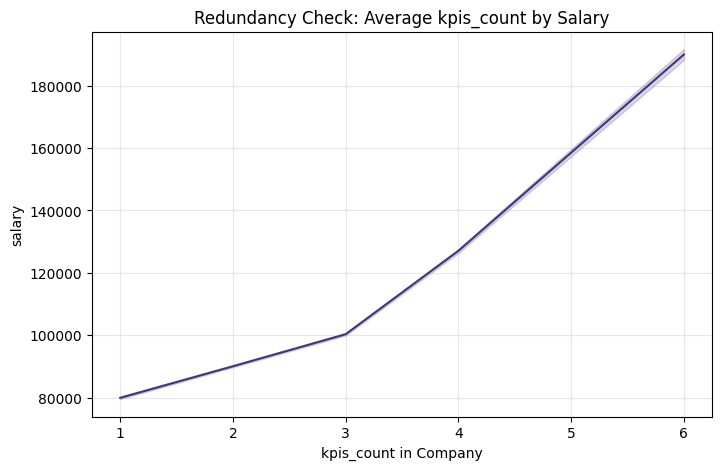

In [20]:
high_corr_pair2 = ['role_level', 'salary']

plt.figure(figsize=(8, 5))

sns.lineplot(x='kpis_count', y='salary', data=df_cleaned)

plt.title('Redundancy Check: Average kpis_count by Salary')
plt.xlabel('kpis_count in Company')
plt.ylabel('salary')
plt.grid(True, alpha=0.3)
plt.show()

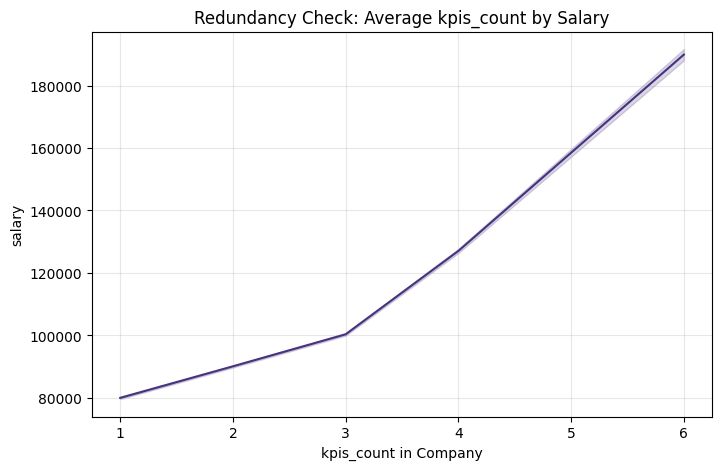

In [21]:
high_corr_pair2 = ['kpis_count', 'salary']

plt.figure(figsize=(8, 5))

sns.lineplot(x='kpis_count', y='salary', data=df_cleaned)

plt.title('Redundancy Check: Average kpis_count by Salary')
plt.xlabel('kpis_count in Company')
plt.ylabel('salary')
plt.grid(True, alpha=0.3)
plt.show()

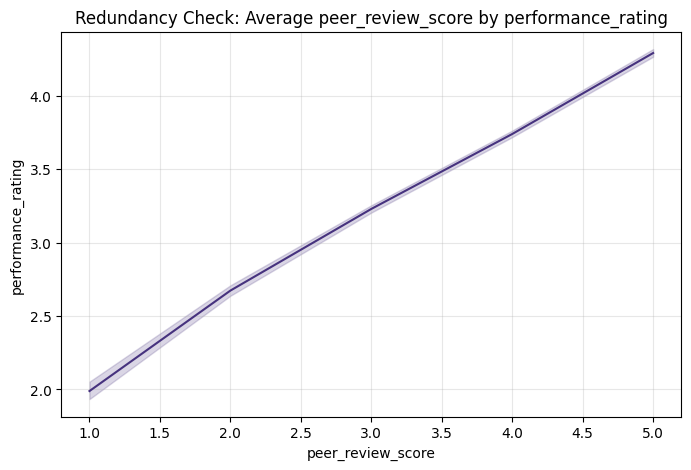

In [22]:
high_corr_pair3 = ['peer_review_score', 'performance_rating']

plt.figure(figsize=(8, 5))

sns.lineplot(x='peer_review_score', y='performance_rating', data=df_cleaned)

plt.title('Redundancy Check: Average peer_review_score by performance_rating')
plt.xlabel('peer_review_score')
plt.ylabel('performance_rating')
plt.grid(True, alpha=0.3)
plt.show()


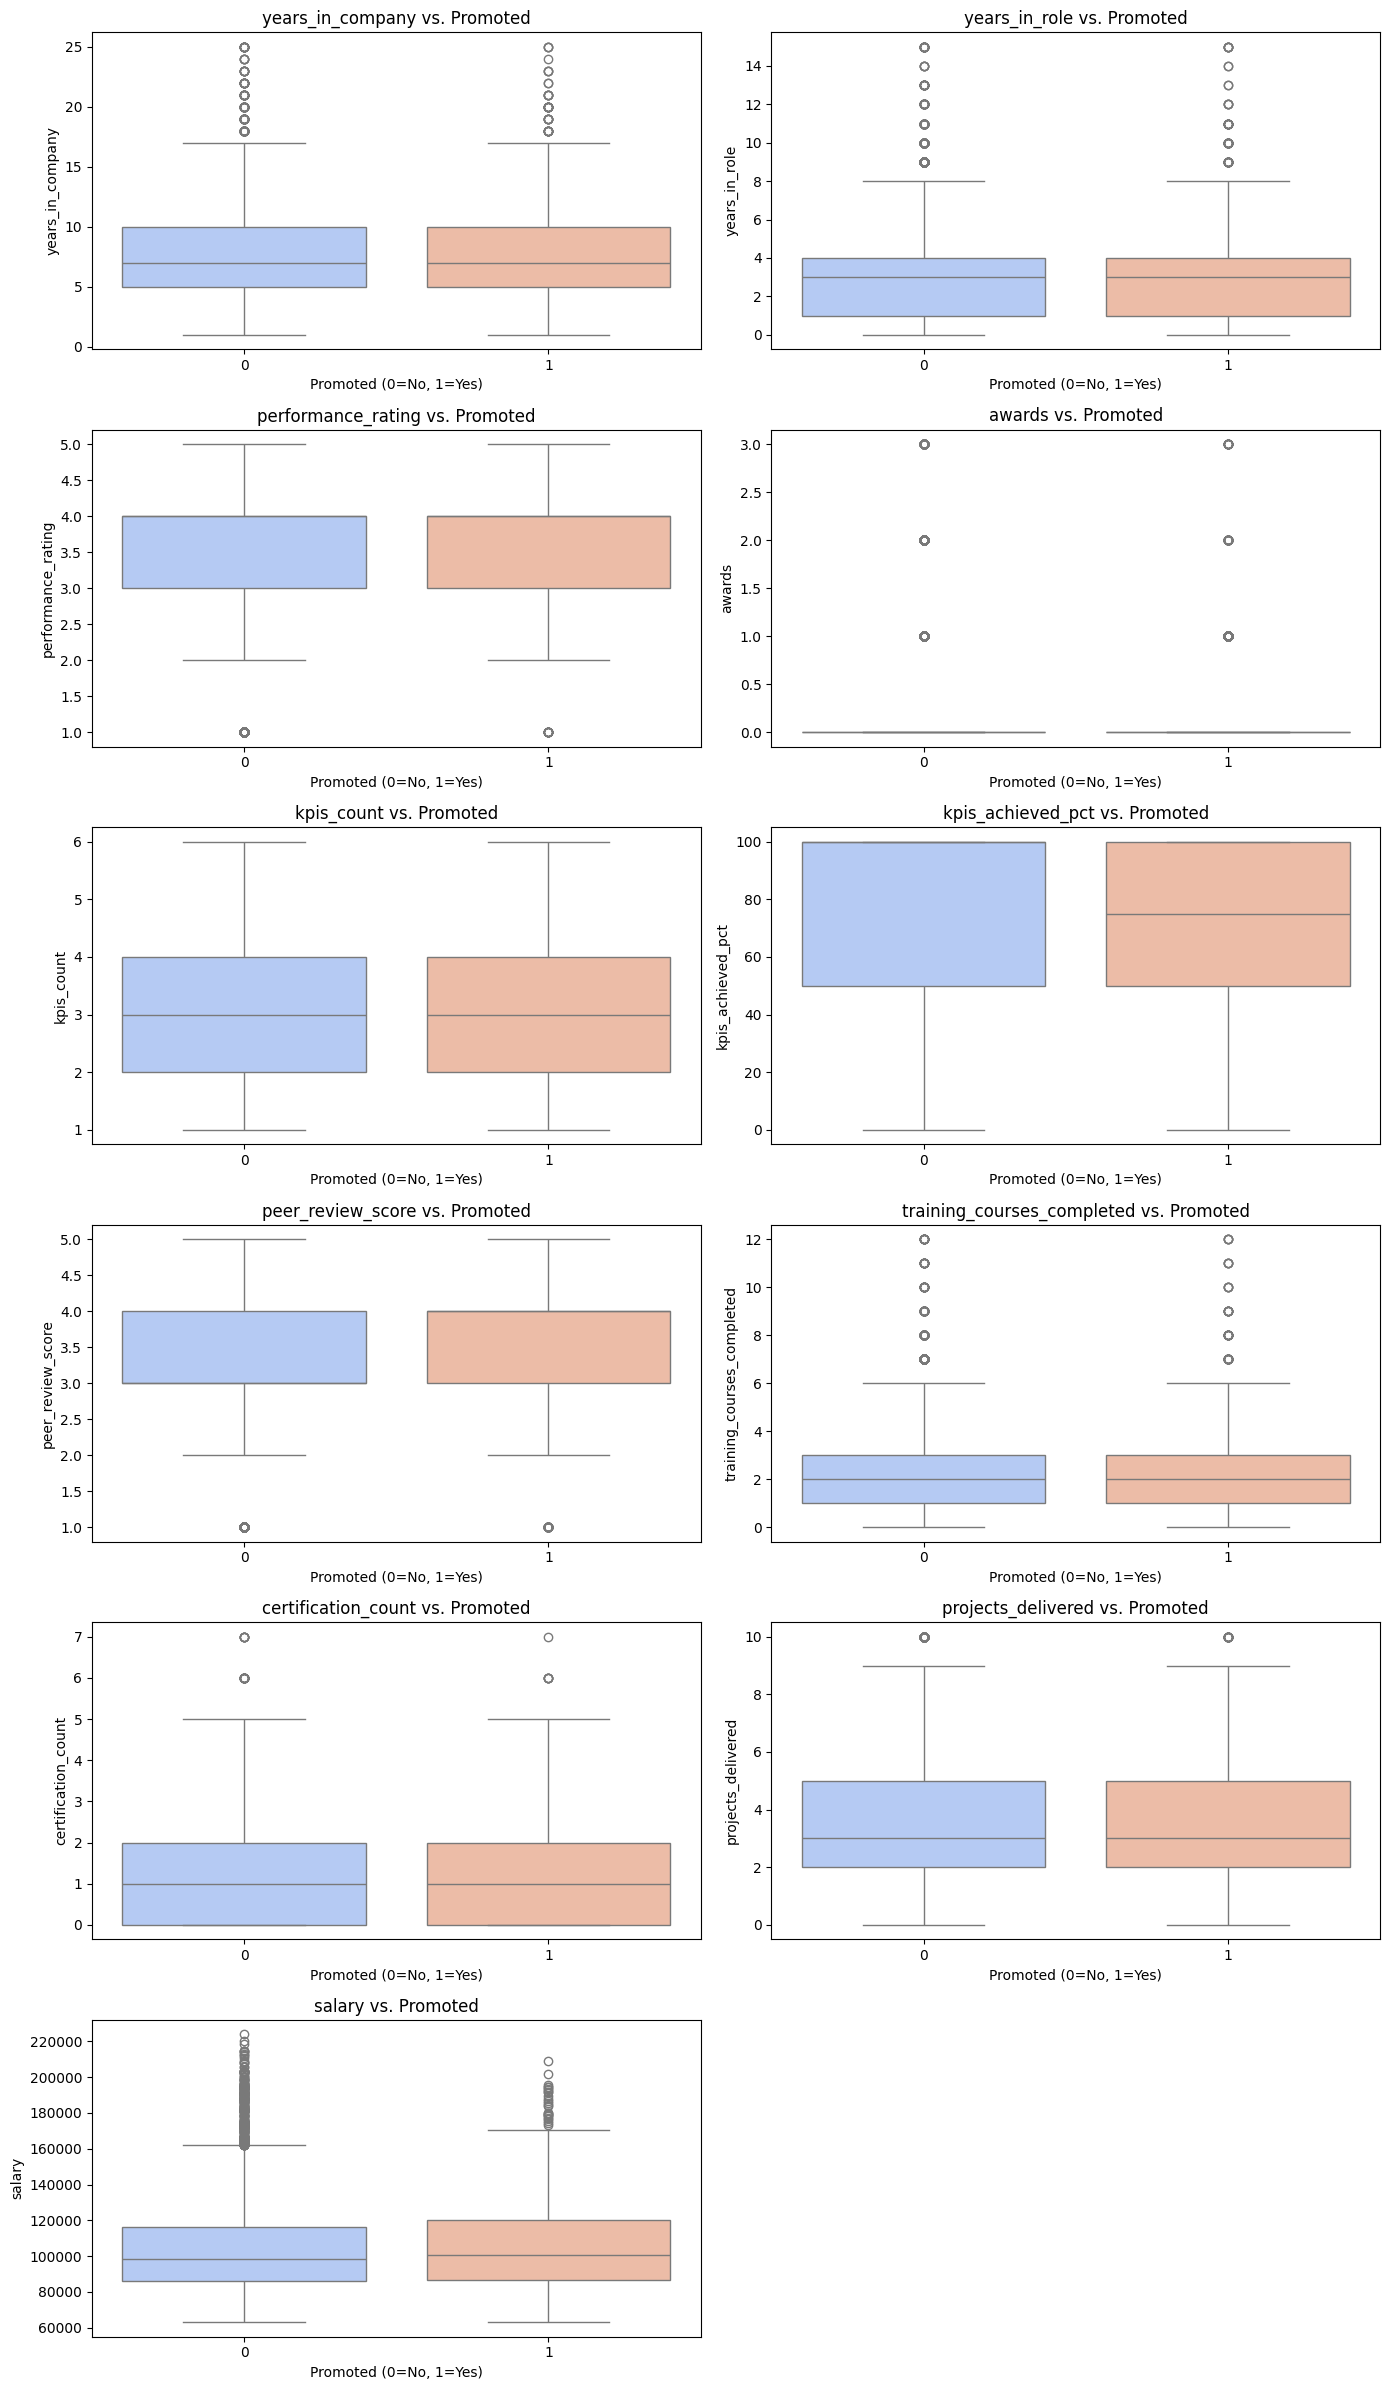

In [23]:
# Create a dynamic grid based on the number of variables
n_cols = 2
n_rows = (len(numeric_vars) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_vars):
    # The crucial plot: Numeric Feature (y) separated by Target Class (x)
    sns.boxplot(x='promoted', y=col, data=df_cleaned, ax=axes[i], palette='coolwarm', hue='promoted', legend=False)
    
    axes[i].set_title(f'{col} vs. Promoted')
    axes[i].set_xlabel('Promoted (0=No, 1=Yes)')
    axes[i].set_ylabel(col)

# Turn off any empty subplots if the grid isn't full
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

##### CATEGORICAL - bivariate

Performance Intervention vs Promoted Crosstab:
promoted                     0     1
performance_intervention            
0                         7556  1584
1                           27     3

Promotion Rate by Performance Intervention Status:
No Intervention: 17.3% promoted
Has Intervention: 10.0% promoted



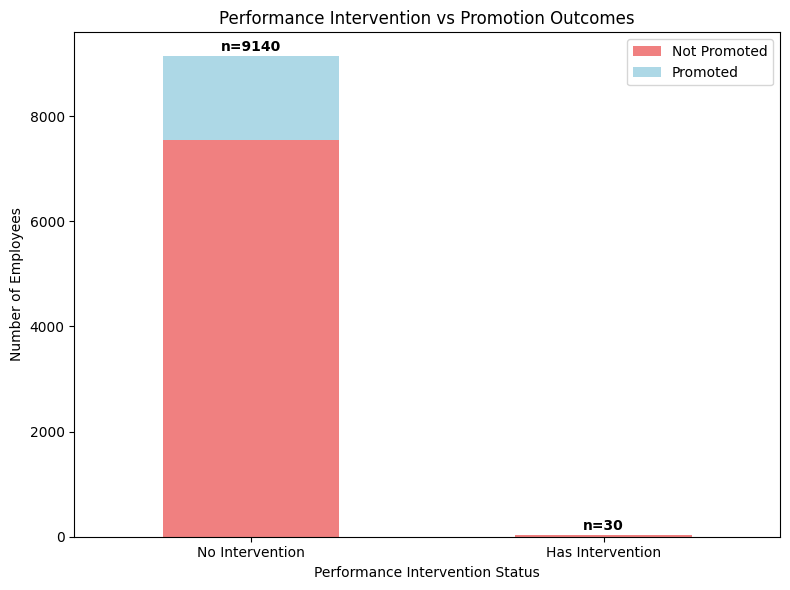

In [24]:
# Create crosstab for performance_intervention vs promoted
intervention_promoted = pd.crosstab(df_cleaned['performance_intervention'], 
                                  df_cleaned['promoted'])

print("Performance Intervention vs Promoted Crosstab:")
print(intervention_promoted)
print()

# Calculate promotion rates
intervention_pct = pd.crosstab(df_cleaned['performance_intervention'], 
                              df_cleaned['promoted'], 
                              normalize='index') * 100

print("Promotion Rate by Performance Intervention Status:")
print(f"No Intervention: {intervention_pct.loc[0, 1]:.1f}% promoted")
print(f"Has Intervention: {intervention_pct.loc[1, 1]:.1f}% promoted")
print()

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(8, 6))

intervention_promoted.plot(kind='bar', stacked=True, ax=ax, 
                          color=['lightcoral', 'lightblue'])

ax.set_title('Performance Intervention vs Promotion Outcomes')
ax.set_xlabel('Performance Intervention Status')
ax.set_ylabel('Number of Employees')
ax.legend(['Not Promoted', 'Promoted'], loc='upper right')
ax.set_xticklabels(['No Intervention', 'Has Intervention'], rotation=0)

# Add count annotations on bars
for i, (idx, row) in enumerate(intervention_promoted.iterrows()):
    total = row.sum()
    ax.text(i, total + 50, f'n={total}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

promoted             0     1
department                  
Customer Success  0.83  0.17
Data Analytics    0.88  0.12
Engineering       0.83  0.17
Finance           0.83  0.17
HR                0.82  0.18
Legal             0.81  0.19
Marketing         0.83  0.17
Operations        0.82  0.18
Product           0.83  0.17
Sales             0.82  0.18


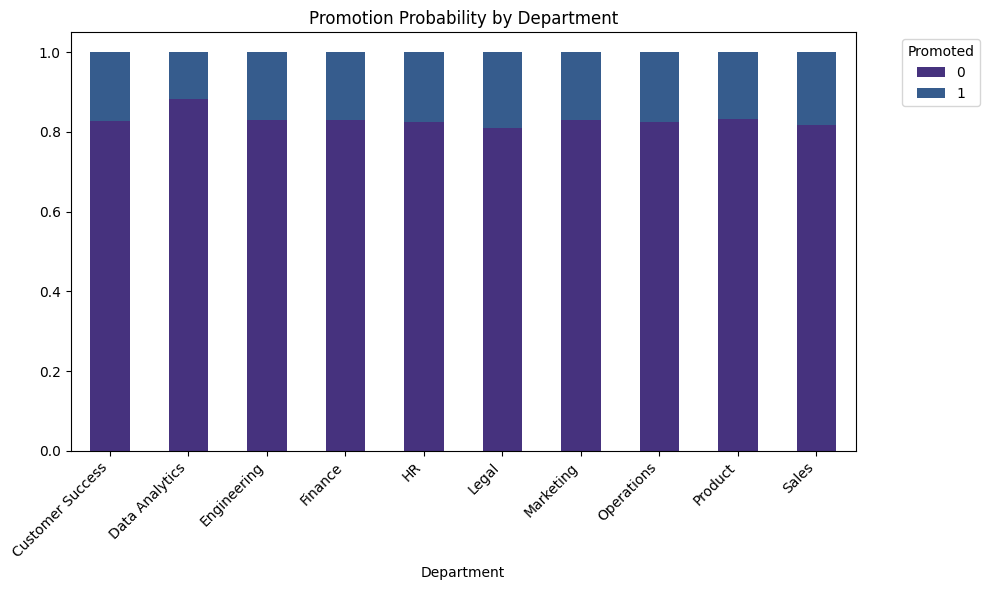

In [25]:
# department
ct_dept = pd.crosstab(df_cleaned['department'], df_cleaned['promoted'], normalize='index')
print(ct_dept.round(2))

ct_dept.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Promotion Probability by Department')
plt.xlabel('Department')
plt.legend(title='Promoted', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


promoted       0     1
role_level            
IC1         0.84  0.16
IC2         0.83  0.17
IC3         0.84  0.16
IC4         0.81  0.19
M1          0.81  0.19
M2          0.80  0.20
M3          0.87  0.13


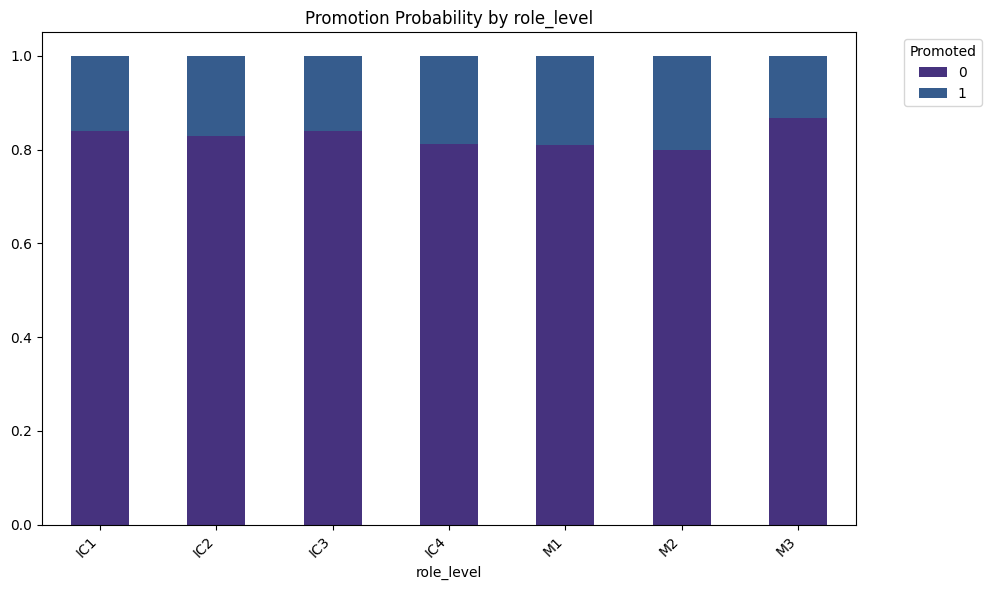

In [26]:
# role_level
ct_role_level= pd.crosstab(df_cleaned['role_level'], df_cleaned['promoted'], normalize='index')
print(ct_role_level.round(2))
ct_role_level.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Promotion Probability by role_level')
plt.xlabel('role_level')
plt.legend(title='Promoted', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


promoted            0     1
education_level            
Associates       0.84  0.16
Bachelors        0.82  0.18
High School      0.87  0.13
Masters          0.82  0.18
Other            0.85  0.15
PhD              0.83  0.17


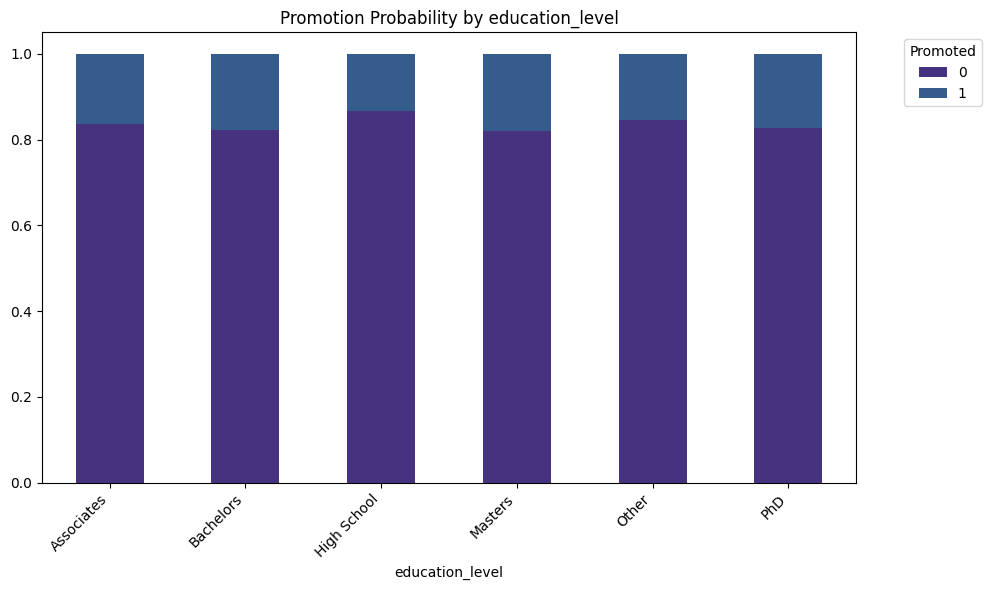

In [27]:
# education_level
ct_education_level= pd.crosstab(df_cleaned['education_level'], df_cleaned['promoted'], normalize='index')
print(ct_education_level.round(2))
ct_education_level.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Promotion Probability by education_level')
plt.xlabel('education_level')
plt.legend(title='Promoted', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


promoted                     0     1
mentorship_participation            
0                         0.83  0.17
1                         0.82  0.18


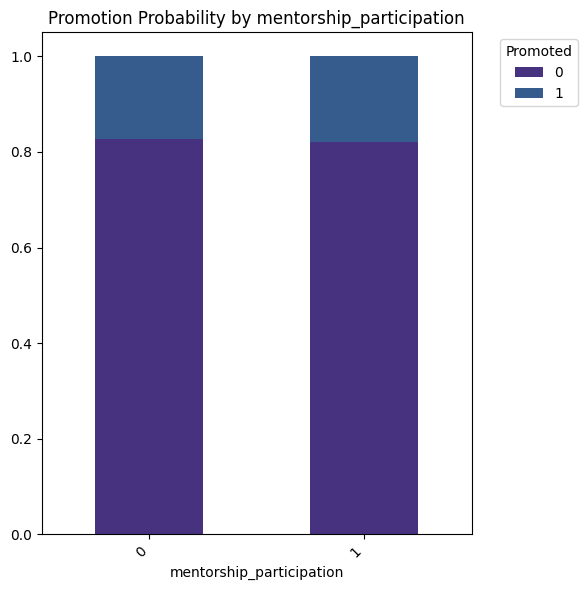

In [28]:
# mentorship_participation
ct_mentorship_participation= pd.crosstab(df_cleaned['mentorship_participation'], df_cleaned['promoted'], normalize='index')
print(ct_mentorship_participation.round(2))
ct_mentorship_participation.plot(kind='bar', stacked=True, figsize=(6, 6))

plt.title('Promotion Probability by mentorship_participation')
plt.xlabel('mentorship_participation')
plt.legend(title='Promoted', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


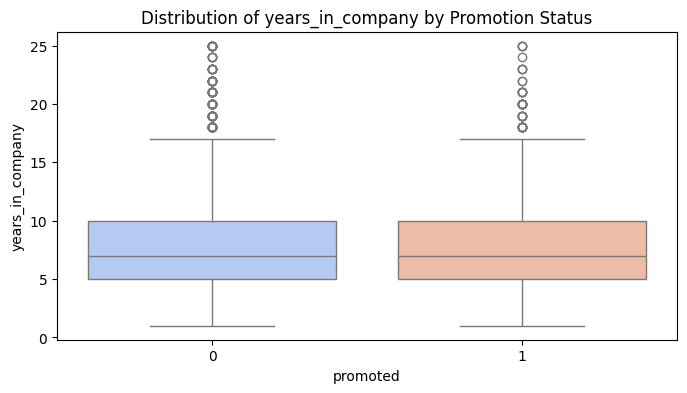

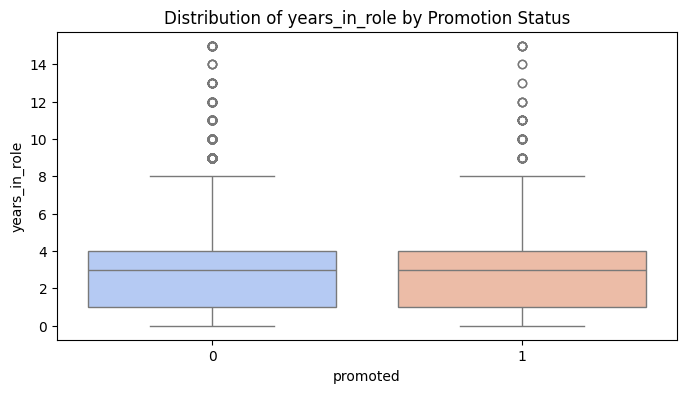

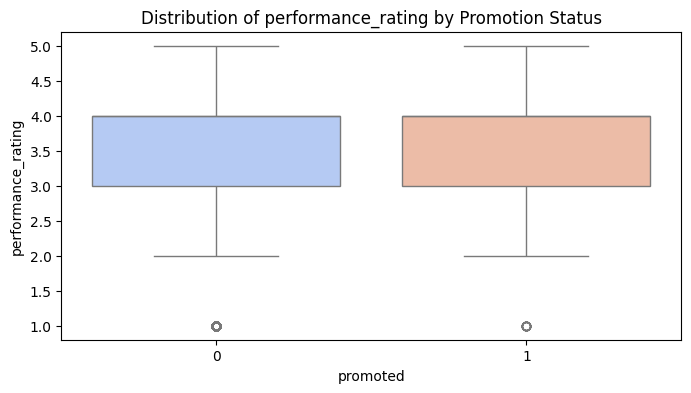

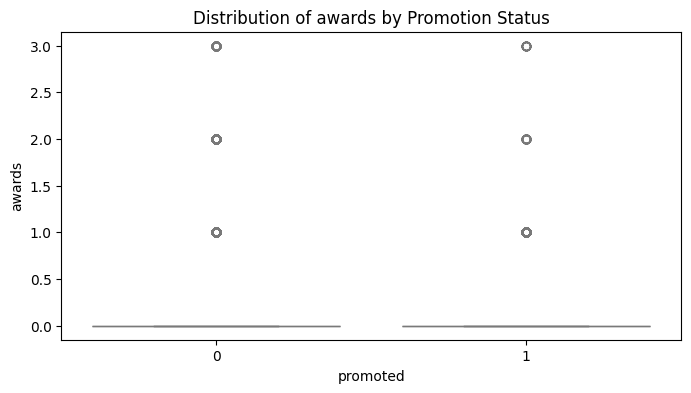

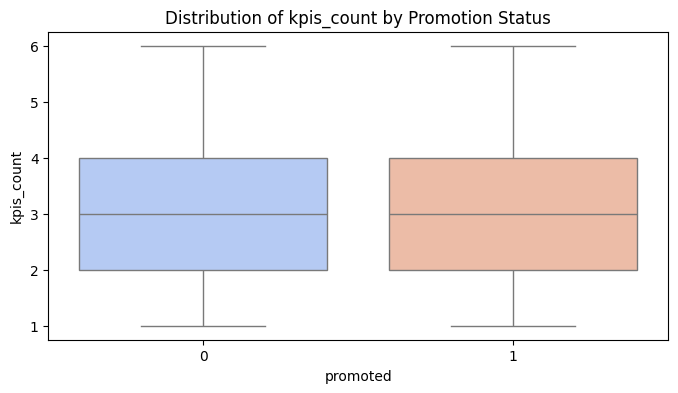

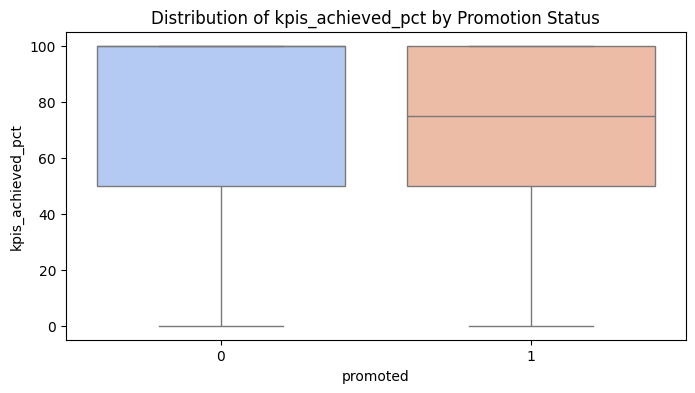

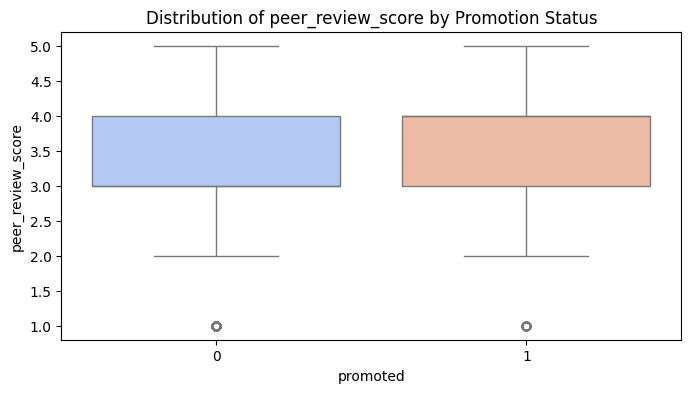

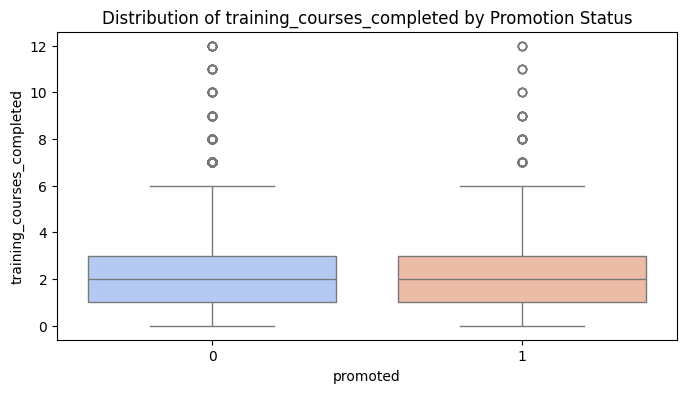

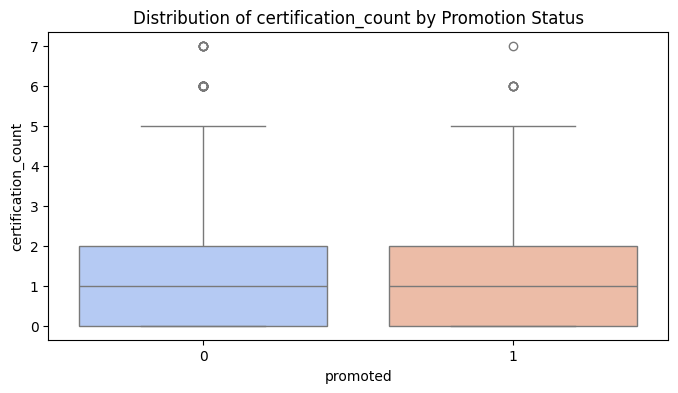

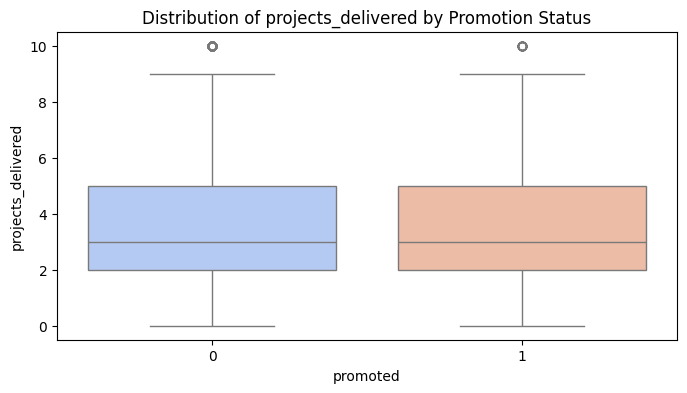

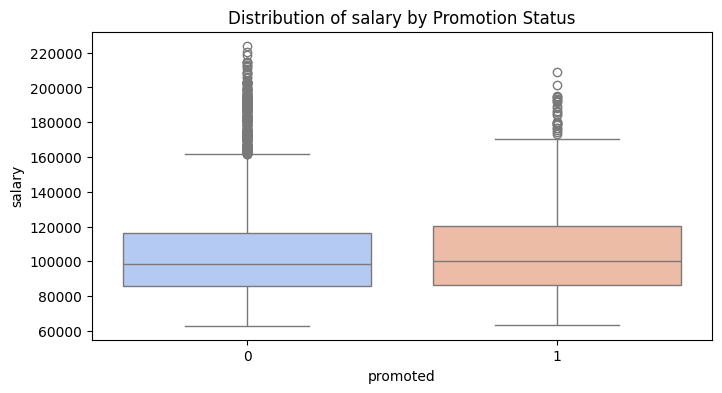

In [29]:
# 
for col in numeric_vars:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='promoted', y=col, data=df_cleaned, palette='coolwarm', hue='promoted', legend=False)
    plt.title(f'Distribution of {col} by Promotion Status')
    plt.show()


In [30]:
# Check the "Rule" mapping for role_level
print(pd.crosstab(df_cleaned['role_level'], df_cleaned['kpis_count']))

kpis_count     1     2     3     4    6
role_level                             
IC1         1824     0     0     0    0
IC2            0  2277     0     0    0
IC3            0     0  1793     0    0
IC4            0     0     0  1353    0
M1             0     0     0  1170    0
M2             0     0     0   579    0
M3             0     0     0     0  174


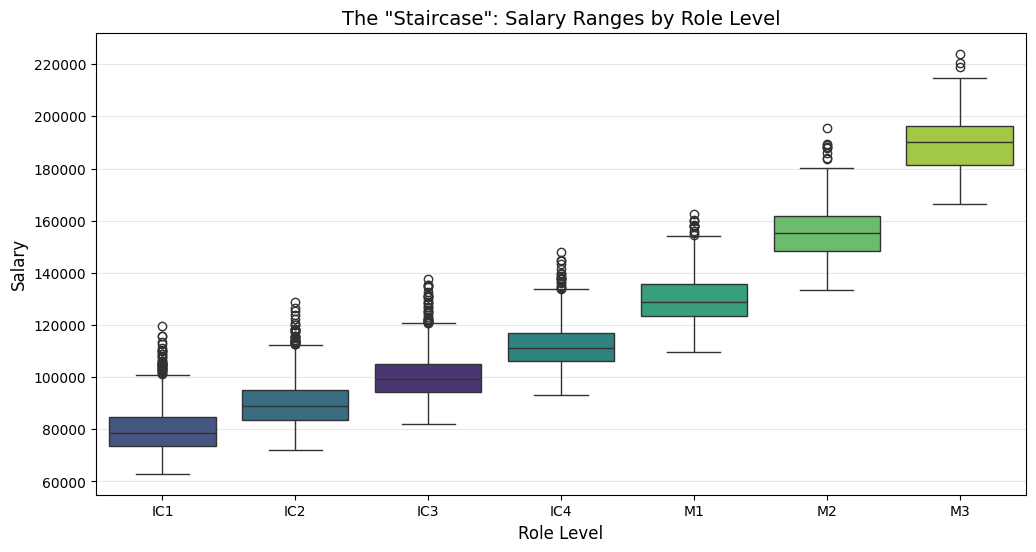

In [31]:
# Visualize role_order by salary
role_order = ['IC1', 'IC2', 'IC3', 'IC4', 'M1', 'M2', 'M3'] 


plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df_cleaned, 
    x='role_level', 
    y='salary', 
    order=role_order, 
    palette='viridis',
    hue='role_level',
    legend=False
)

plt.title('The "Staircase": Salary Ranges by Role Level', fontsize=14)
plt.ylabel('Salary', fontsize=12)
plt.xlabel('Role Level', fontsize=12)
plt.grid(True, axis='y', alpha=0.3) 

plt.show()

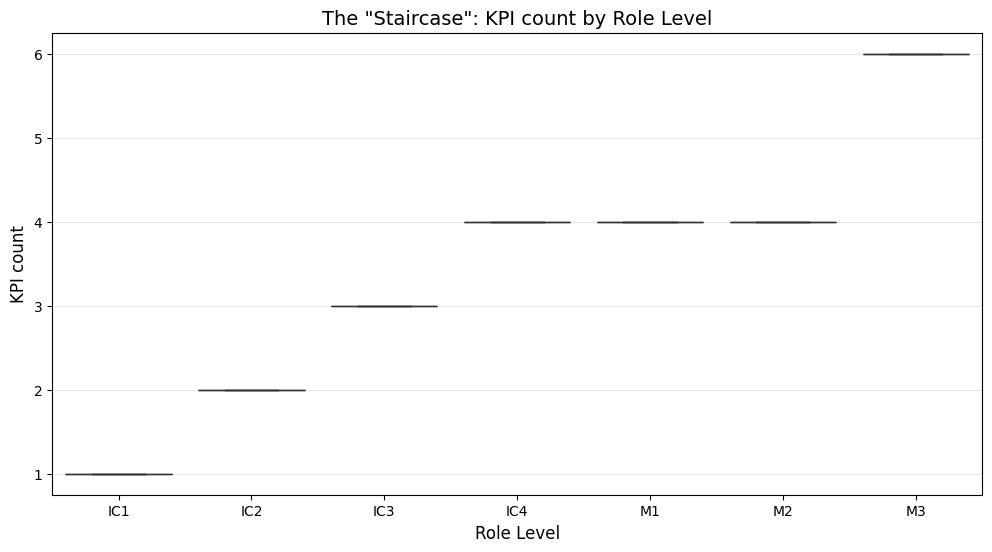

In [32]:
# role-level by kpis_count
role_order = ['IC1', 'IC2', 'IC3', 'IC4', 'M1', 'M2', 'M3'] 


plt.figure(figsize=(12, 6))

sns.boxplot(
    data=df_cleaned, 
    x='role_level', 
    y='kpis_count', 
    order=role_order, 
    palette='viridis',
    hue='role_level',
    legend=False
)

plt.title('The "Staircase": KPI count by Role Level', fontsize=14)
plt.ylabel('KPI count', fontsize=12)
plt.xlabel('Role Level', fontsize=12)
plt.grid(True, axis='y', alpha=0.3)

plt.show()

### Root Cause Discovery: Salary & KPIs Are Proxies for Role Level

The "staircase" pattern shows that:
- **Salary increases by role tier** (Entry ~$50K to Director ~$250K)
- **KPI counts scale with seniority** (Entry ~2 KPIs to Director ~8 KPIs)

**Implication**: These variables measure *organizational structure*, not individual merit.  
Including them in a promotion model would create circular logic (promoted because 
senior → senior because promoted).

**Decision**: Exclude `salary` and `kpis_count` from model features.

**Next Step**: Variance Inflation Factor (VIF) analysis to quantify multicollinearity 
and determine which variables to exclude from the model.

In [33]:
selected_numeric_vars = [
    'years_in_role', 
    'performance_rating', 
    'awards', 
    'kpis_achieved_pct', 
    'peer_review_score', 
    'training_courses_completed', 
    'certification_count', 
    'mentorship_participation', 
    'projects_delivered']

# Set constant for VIF calculation input requirement
X = add_constant(df_cleaned[selected_numeric_vars])
     
# Calculate variable inflation factor over each column and set up in data frame
vif = pd.DataFrame()
vif["variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.sort_values(by='VIF', ascending=False)



,variable,VIF
0,const,26.2073
2,performance_rating,2.0256
5,peer_review_score,1.9658
6,training_courses_completed,1.2306
1,years_in_role,1.2158
9,projects_delivered,1.0495
3,awards,1.0146
8,mentorship_participation,1.0084
7,certification_count,1.0070
4,kpis_achieved_pct,1.0070


## Final Feature Set for Modeling

**Excluded Variables** (and rationale):
- `salary`, `kpis_count`: Proxies for role_level (VIF > 10)
- `years_in_company`: Redundant with years_in_role (VIF = 7.9)
- `employee_id`, `manager_id`: Identifiers, not predictors

**Retained Variables** (11 features):
1. `role_level` (categorical: Entry → Director)
2. `education_level` (categorical: High School → PhD)
3. `years_in_role` (tenure in current position)
4. `performance_rating` (1-5 scale)
5. `awards` (recognition count)
6. `kpis_achieved_pct` (goal attainment %)
7. `peer_review_score` (360° feedback)
8. `training_courses_completed`
9. `certification_count`
10. `mentorship_participation` (binary)
11. `projects_delivered` (initiative count)

**Trade-off Note**: Kept `performance_rating` and `peer_review_score` despite 
high correlation (ρ = 0.84) because they represent different evaluation frameworks 
(manager assessment vs peer feedback).

##### Ordinal Encoding

In [34]:
role_mapping = {'IC1': 1, 'IC2': 2, 'IC3': 3, 'IC4': 4, 'M1': 5, 'M2': 6, 'M3': 7}
edu_mapping = {'High School': 1, 'Associates': 2, 'Other': 3, 'Bachelors': 4, 'Masters': 5, 'PhD': 6}

df_cleaned['role_level_encoded'] = df_cleaned['role_level'].map(role_mapping)
df_cleaned['education_level_encoded'] = df_cleaned['education_level'].map(edu_mapping)

In [35]:
# Model Numeric variables

independent_numeric = [
    'years_in_role', 
    'performance_rating', 
    'awards', 
    'kpis_achieved_pct', 
    'peer_review_score', 
    'training_courses_completed', 
    'certification_count', 
    'mentorship_participation', 
    'projects_delivered']

# Model Encoded Categorical variables
independent_categorical = ['role_level_encoded','education_level_encoded']  

# Target Variable
dependent_var = ['promoted']

df_model = df_cleaned[independent_numeric + independent_categorical + dependent_var] 

#### Data Preprocessing

In [36]:
## Train/test split

X = df_model.drop(columns=["promoted"])   

y = df_model["promoted"]      
            
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Original data shape: ", df_model.shape)

training_data = pd.concat([y_train, X_train], axis=1)
print("Training data shape: ", training_data.shape)

testing_data = pd.concat([y_test, X_test], axis=1)
print("Testing data shape: ", testing_data.shape)


Original data shape:  (9170, 12)
Training data shape:  (7336, 12)
Testing data shape:  (1834, 12)


In [37]:
# Training
training_data = pd.concat([y_train, X_train], axis=1)
training_data.to_csv("../data/train.csv", index=False)

# Testing
testing_data = pd.concat([y_test, X_test], axis=1)
testing_data.to_csv("../data/test.csv", index=False)

### TRAINING

##### Training

In [38]:
# Specify null base model - no independent variables
mdl_0 = logit("promoted ~ 1", data=training_data).fit()
print(mdl_0.summary2())

Optimization terminated successfully.
         Current function value: 0.463557
         Iterations 5
                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: promoted         Pseudo R-squared: 0.000    
Date:               2026-02-11 17:03 AIC:              6803.3128
No. Observations:   7336             BIC:              6810.2133
Df Model:           0                Log-Likelihood:   -3400.7  
Df Residuals:       7335             LL-Null:          -3400.7  
Converged:          1.0000           LLR p-value:      nan      
No. Iterations:     5.0000           Scale:            1.0000   
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
Intercept   -1.5514    0.0307  -50.4754  0.0000  -1.6116  -1.4911



In [39]:
mdl_standardized = logit(
    "promoted ~ years_in_role + performance_rating + awards + "
    "kpis_achieved_pct + peer_review_score + training_courses_completed + "
    "certification_count + projects_delivered + role_level_encoded + "
    "education_level_encoded",
    data=training_data
).fit()

print(mdl_standardized.summary2())

Optimization terminated successfully.
         Current function value: 0.458077
         Iterations 6
                              Results: Logit
Model:                 Logit               Method:              MLE       
Dependent Variable:    promoted            Pseudo R-squared:    0.012     
Date:                  2026-02-11 17:03    AIC:                 6742.9096 
No. Observations:      7336                BIC:                 6818.8157 
Df Model:              10                  Log-Likelihood:      -3360.5   
Df Residuals:          7325                LL-Null:             -3400.7   
Converged:             1.0000              LLR p-value:         4.1851e-13
No. Iterations:        6.0000              Scale:               1.0000    
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                  -

### TESTING

In [40]:
# GENERATE TEST PREDICTIONS
y_prob_std = mdl_standardized.predict(X_test)
y_actual_std = testing_data['promoted']

In [41]:
# summary statistics of test predictions
print("Test Set Prediction Summary:")
print(f"Mean probability: {y_prob_std.mean():.4f}")
print(f"Max probability: {y_prob_std.max():.4f}")
print(f"Min probability: {y_prob_std.min():.4f}")
print(f"Standard deviation: {y_prob_std.std():.4f}")
print()

# distribution of predictions
print("Prediction Distribution:")
print(f"25th percentile: {np.percentile(y_prob_std, 25):.4f}")
print(f"50th percentile (median): {np.percentile(y_prob_std, 50):.4f}")
print(f"75th percentile: {np.percentile(y_prob_std, 75):.4f}")
print()

# Count how many predictions are above 0.14 threshold
above_threshold = (y_prob_std > 0.14).sum()
total_predictions = len(y_prob_std)
print(f"Predictions above 0.14 threshold: {above_threshold} out of {total_predictions} ({above_threshold/total_predictions*100:.1f}%)")


Test Set Prediction Summary:
Mean probability: 0.1741
Max probability: 0.3432
Min probability: 0.0887
Standard deviation: 0.0401

Prediction Distribution:
25th percentile: 0.1451
50th percentile (median): 0.1682
75th percentile: 0.1974

Predictions above 0.14 threshold: 1472 out of 1834 (80.3%)


In [42]:
# PRINT default thresh STANDARDIZED MODEL METRICS
print(f"--- DEFAULT THRESHOLD MODEL PERFORMANCE  ---")
thresh_default = 0.50

# Convert probabilities to 0/1 using the default threshold
y_pred_final = (y_prob_std >= thresh_default).astype(int)

# 1. Standard Classification Report
print(classification_report(y_actual_std, y_pred_final, zero_division=0))

# 2. The Hero Metrics (Recall & F2)
recall_val = recall_score(y_actual_std, y_pred_final)
f2_val = fbeta_score(y_actual_std, y_pred_final, beta=2)

print("-" * 30)
print(f"Recall:   {recall_val:.2f} ")
print(f"F2 Score: {f2_val:.2f}")

--- DEFAULT THRESHOLD MODEL PERFORMANCE  ---
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1530
           1       0.00      0.00      0.00       304

    accuracy                           0.83      1834
   macro avg       0.42      0.50      0.45      1834
weighted avg       0.70      0.83      0.76      1834

------------------------------
Recall:   0.00 
F2 Score: 0.00


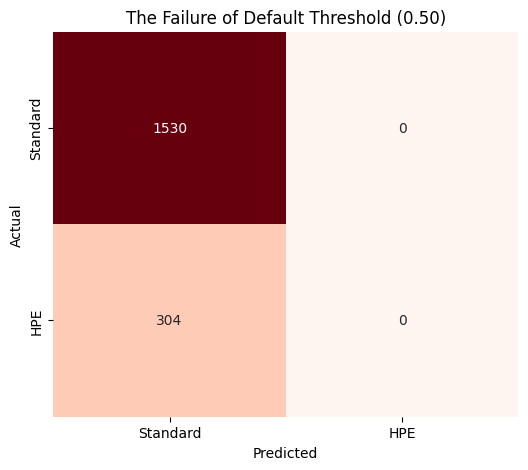

In [43]:
# The "Bad" Matrix at 0.50
plt.figure(figsize=(6, 5))

# Predict using default (0.50)
pred_default = (y_prob_std >= 0.50).astype(int)
cm_opt = confusion_matrix(y_actual_std, pred_default)

# Plot
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Reds', cbar=False) # Using Red to signal "Bad"
plt.title('The Failure of Default Threshold (0.50)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Standard', 'HPE'])
plt.yticks([0.5, 1.5], ['Standard', 'HPE'])

plt.show()

### THE ACCURACY PARADOX

**Observation**: At the default 0.50 probability threshold, the model predicts 
**ZERO promotions** (empty confusion matrix at test, near-empty on full data).

**Why This Happens**:
1. Class imbalance (17% promoted) biases probabilities downward
2. Max predicted probability: 0.26 (well below 0.50 threshold)
3. Model optimizes for overall accuracy → predicts majority class

**The Problem**: 
- Accuracy = 83% (sounds good!)
- Recall = 0% (catastrophic failure)
- **Translation**: Model catches NONE of the promotable talent

**Solution**: Optimize threshold using precision-recall curve to prioritize recall 
(talent safety net) over precision.

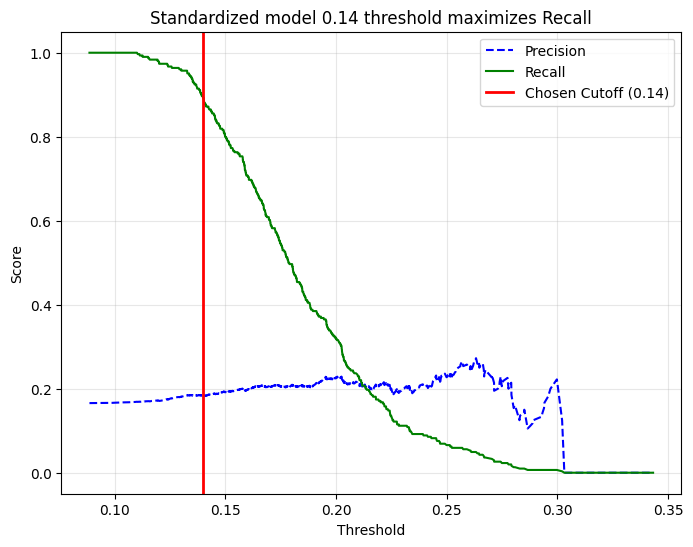

In [44]:
# PLOT 3: PRECISION-RECALL CURVE (STANDARDIZED MODEL)
thresh_default = 0.5
thresh_final_std = 0.14

plt.figure(figsize=(8, 6))

precision, recall, thresholds = precision_recall_curve(y_actual_std, y_prob_std)

plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')

# Mark the chosen threshold
plt.axvline(x=thresh_final_std, color='red', lw=2, label=f'Chosen Cutoff ({thresh_final_std})')

plt.title(f'Standardized model {thresh_final_std} threshold maximizes Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(alpha=0.3)

plt.show()

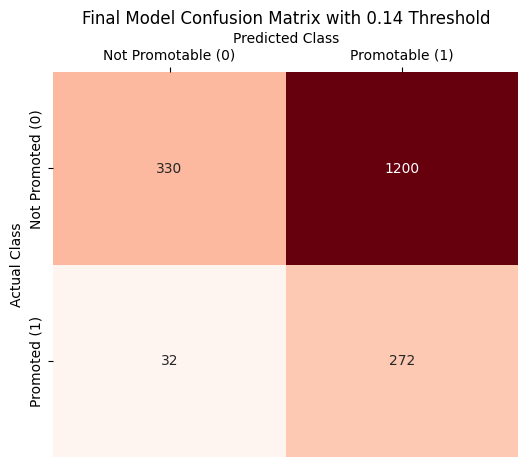

In [45]:
# The "Final" Matrix at 0.14

thresh_final_std = 0.14
plt.figure(figsize=(6, 5))

# Set 0.14 threshold
pred_default_std = (y_prob_std >= thresh_final_std).astype(int)

# Create Matrix (sklearn default is [0, 1] -> [Negative, Positive])
cm_std = confusion_matrix(y_actual_std, pred_default_std)

# Plot
sns.heatmap(cm_std, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('Final Model Confusion Matrix with 0.14 Threshold')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.xticks([0.5, 1.5], ['Not Promotable (0)', 'Promotable (1)']) 
plt.yticks([0.5, 1.5], ['Not Promoted (0)', 'Promoted (1)']) 
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

plt.show()

In [46]:
# FINAL standardized model test with new threshold
thresh_final_std = 0.14

print(f"--- STANDARDIZED MODEL TEST PERFORMANCE (Threshold 0.14) ---")

y_actual_std = testing_data['promoted']
y_pred_final = (y_prob_std >= thresh_final_std).astype(int)

# 1. Standard Classification Report
print(classification_report(y_actual_std, y_pred_final, zero_division=0))

# 2. The Hero Metrics (Recall & F2)
recall_val = recall_score(y_actual_std, y_pred_final)
f2_val = fbeta_score(y_actual_std, y_pred_final, beta=2)

print("-" * 30)
print(f"Recall:   {recall_val:.2f} ")
print(f"F2 Score: {f2_val:.2f}")

--- STANDARDIZED MODEL TEST PERFORMANCE (Threshold 0.14) ---
              precision    recall  f1-score   support

           0       0.91      0.22      0.35      1530
           1       0.18      0.89      0.31       304

    accuracy                           0.33      1834
   macro avg       0.55      0.56      0.33      1834
weighted avg       0.79      0.33      0.34      1834

------------------------------
Recall:   0.89 
F2 Score: 0.51


## Model Performance Summary

### Optimized Threshold: 0.14

| Metric | Value | Interpretation |
|--------|-------|----------------|
| **Recall** | 89% | Catches 9 out of 10 promotable employees |
| **Precision** | 19% | 1 in 5 employees are actually promotable |
| **F2 Score** | 0.51 | Balanced metric favoring recall |
| **Pseudo R²** | 0.012 | Only 1.2% of variance explained |

### Strategic Interpretation

**Low R² = Process Dysfunction, Not Model Failure**

The model's low explanatory power reveals that **98.8% of promotion decisions 
are disconnected from documented merit criteria**. This is the diagnostic finding 
that drives process redesign recommendations.

**Model Utility**:
- Talent identification (89% recall ensures high-performers aren't overlooked)
- Bias audit compliance (interpretable coefficients)
- Process monitoring (annual retraining tracks organizational alignment)

## Verification of Assumptions for Logistic Regression

### Sufficient sample size

In [47]:
# Check sample size
num_features = df_model.drop(columns=['promoted']).shape[1]
num_events = df_model['promoted'].sum()
min_count = df_model['promoted'].value_counts().min()

#Events Per Variable (EPV)
epv = min_count / num_features

print(f"Number of Features: {num_features}")
print(f"Number of Events (Minority Class): {min_count}")
print(f"Events Per Variable (EPV): {epv:.2f}")

Number of Features: 11
Number of Events (Minority Class): 1587
Events Per Variable (EPV): 144.27


### Linearity of Log-Odds 

Logistic regression requires continuous predictors to have a linear relationship 
with the log-odds of the outcome. Visual inspection confirms this assumption holds 
for both `years_in_role` and `kpis_achieved_pct`.

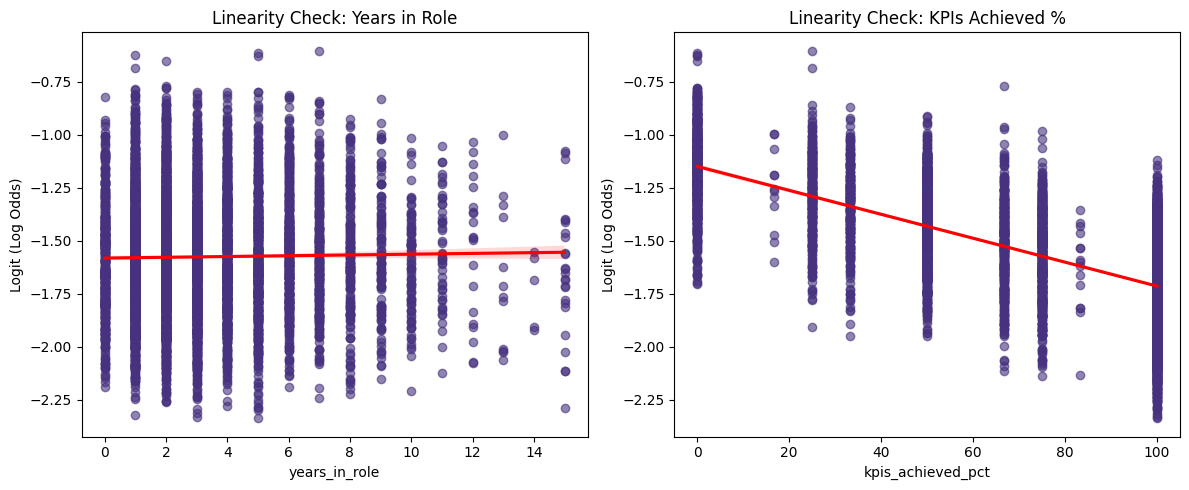

In [48]:
# Generate logits from training predictions
y_prob_train = mdl_standardized.predict(X_train)
logits_train = np.log(y_prob_train / (1 - y_prob_train))

# Plot linearity for continuous variables
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# years_in_role 
sns.regplot(x=X_train['years_in_role'], y=logits_train, ax=axes[0], scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
axes[0].set_title('Linearity Check: Years in Role')
axes[0].set_ylabel('Logit (Log Odds)')

# kpis_achieved_pct 
sns.regplot(x=X_train['kpis_achieved_pct'], y=logits_train, ax=axes[1], scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
axes[1].set_title('Linearity Check: KPIs Achieved %')
axes[1].set_ylabel('Logit (Log Odds)')

plt.tight_layout()
plt.show()

### Independence of Observations

Each record represents a unique employee evaluation at a single point in time. 
There are no repeated measures, hierarchical structures, or temporal dependencies 
that would violate the independence assumption. Employees are evaluated 
independently across different departments and managers.

##### Influential Outliers

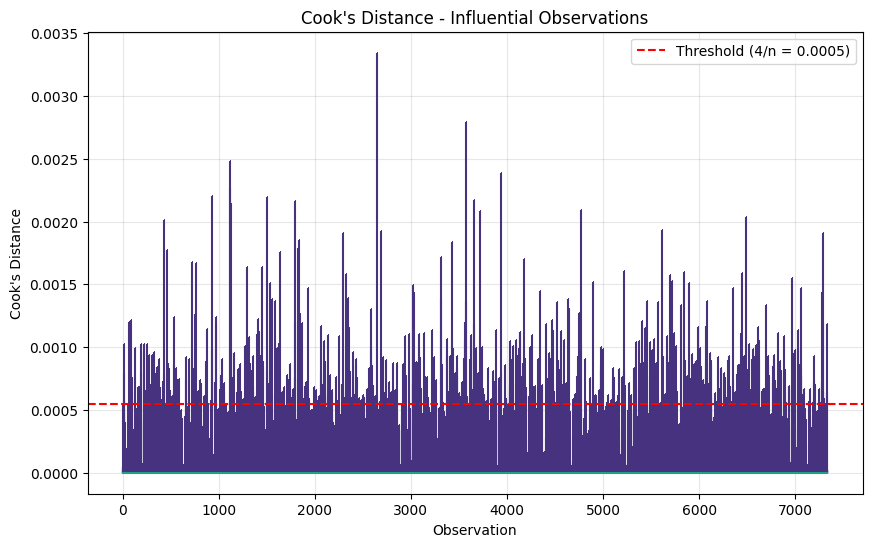

Observations with Cook's D > 0.0005: 664


In [49]:
# Calculate Cook's distance
influence = mdl_standardized.get_influence()
cooks_d = influence.cooks_distance[0]

# Plot 
plt.figure(figsize=(10, 6))
plt.stem(range(len(cooks_d)), cooks_d, markerfmt=",")
plt.xlabel('Observation')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance - Influential Observations")
plt.axhline(y=4/len(cooks_d), color='r', linestyle='--', label=f'Threshold (4/n = {4/len(cooks_d):.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# influential observations
threshold = 4/len(cooks_d)
influential = cooks_d > threshold
print(f"Observations with Cook's D > {threshold:.4f}: {influential.sum()}")

### Model Run on full data for probabilities

In [50]:
X_full = df_model.drop(columns=['promoted'])
X_full_const = sm.add_constant(X_full)

full_probabilities = mdl_standardized.predict(X_full_const)

# 4. Append to df_cleaned
df_cleaned['probability'] = full_probabilities

df_cleaned['prediction_promoted'] = (full_probabilities >= 0.14).astype(int)


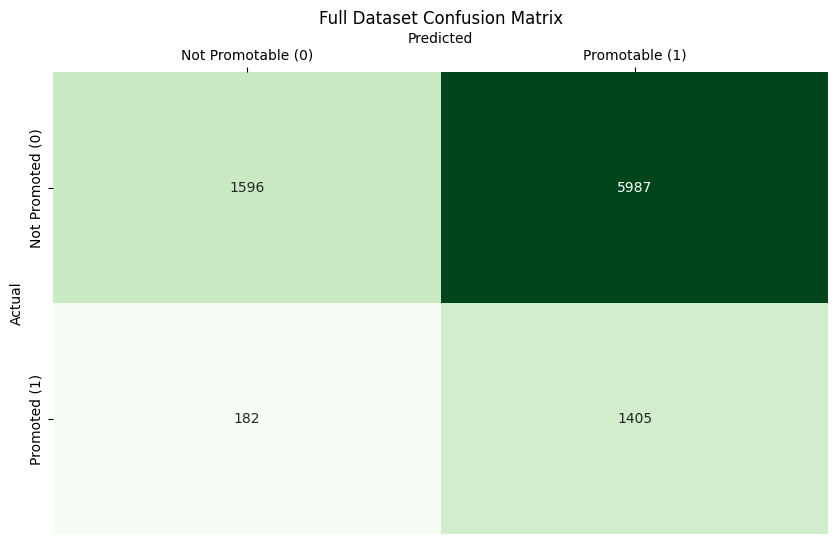

In [51]:
final_y_actual = df_cleaned['promoted']
final_preds = df_cleaned['prediction_promoted']

cm_full = confusion_matrix(final_y_actual, final_preds)

sns.heatmap(cm_full, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Full Dataset Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Not Promotable (0)', 'Promotable (1)']) 
plt.yticks([0.5, 1.5], ['Not Promoted (0)', 'Promoted (1)']) 
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')



In [52]:
print(f"--- FINAL FULL DATASET MODEL PERFORMANCE ---")

final_y_actual = df_cleaned['promoted']
final_preds = df_cleaned['prediction_promoted']

print(classification_report(final_y_actual, final_preds, zero_division=0))

# Recall & F2
recall_val = recall_score(final_y_actual, final_preds)
f2_val = fbeta_score(final_y_actual, final_preds, beta=2)

print("-" * 30)
print(f"Recall:   {recall_val:.2f}")
print(f"F2 Score: {f2_val:.2f} ")

--- FINAL FULL DATASET MODEL PERFORMANCE ---
              precision    recall  f1-score   support

           0       0.90      0.21      0.34      7583
           1       0.19      0.89      0.31      1587

    accuracy                           0.33      9170
   macro avg       0.54      0.55      0.33      9170
weighted avg       0.78      0.33      0.34      9170

------------------------------
Recall:   0.89
F2 Score: 0.51 


In [53]:
# Store results
df_final_predictions = df_cleaned.copy()

#### 9-box Classification

In [54]:
# 9-Box Logic

q_low = df_final_predictions['probability'].quantile(0.25)
q_high = df_final_predictions['probability'].quantile(0.75)

print(f"Dynamic Cutoffs Calculated:")
print(f"Low Potential Boundary (Bottom 25%): < {q_low:.4f}")
print(f"High Potential Boundary (Top 25%): > {q_high:.4f}")

def get_grid(row):
    if row['performance_rating'] <= 2: perf = 'Low'
    elif row['performance_rating'] == 3: perf = 'Moderate'
    else: perf = 'High'
    
    # Potential score (Y-Axis)
    if row['probability'] < q_low: pot = 'Low'
    elif row['probability'] < q_high: pot = 'Moderate'
    else: pot = 'High'
    
    return f"{pot} Potential / {perf} Performance"

df_final_predictions['box_category'] = df_final_predictions.apply(get_grid, axis=1)

# drop encoded cols
final_data = df_final_predictions.drop(columns=['role_level_encoded', 'education_level_encoded']).copy()


Dynamic Cutoffs Calculated:
Low Potential Boundary (Bottom 25%): < 0.1452
High Potential Boundary (Top 25%): > 0.1984


In [55]:
# 9-box counts
summary_table = pd.crosstab(
    final_data['probability'] >= q_high,  
    final_data['performance_rating'] >= 4,    
    rownames=['Is High Potential?'],
    colnames=['Is High Performance?']
)
print(summary_table)
print("\n--- Distribution of Employees ---")
print(final_data['box_category'].value_counts().sort_index())

Is High Performance?  False  True 
Is High Potential?                
False                  3854   3023
True                    672   1621

--- Distribution of Employees ---
box_category
High Potential / High Performance            1621
High Potential / Low Performance              106
High Potential / Moderate Performance         566
Low Potential / High Performance              541
Low Potential / Low Performance               749
Low Potential / Moderate Performance         1003
Moderate Potential / High Performance        2482
Moderate Potential / Low Performance          503
Moderate Potential / Moderate Performance    1599
Name: count, dtype: int64


In [56]:
# Change probability col name to potential 
final_data['potential'] = final_data['probability']
final_data = final_data.drop(columns='probability')


In [57]:
# Send final data with box categories to CSV
final_data.to_csv("../data/final_data.csv", index=False)
final_data.to_csv("../app/final_data.csv", index=False)

In [58]:
print('This code works!')

This code works!
